In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from ta import momentum, trend, volume
from binance import Client
from key import PUB_KEY, SEC_KEY

# Get Historical Data

In [90]:
# Connecting to Binance
client = Client(PUB_KEY, SEC_KEY)
# Get historical data
raw_df = pd.DataFrame(client.get_historical_klines('BTCUSDT',
                             Client.KLINE_INTERVAL_1HOUR,
                                      str(365) + ' days ago UTC'))

# First 6 column represent Time and OHLCV values
raw_df = raw_df.iloc[:, :6]
raw_df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']

# Convert first column into datetime
raw_df['Time'] = pd.to_datetime(raw_df['Time'], unit='ms')
for column in raw_df.columns:
    if column != 'Time':
        raw_df[column] = raw_df[column].astype(float)

# Set Time as index
raw_df.set_index('Time', inplace=True)
raw_df = raw_df.iloc[:-1]

# Generate Technical Indicators

In [91]:
def get_ta(raw_df):
    df = raw_df.copy()
    df['SMA50'] = df['Close'].rolling(50).mean()
    df['SMA200'] = df['Close'].rolling(200).mean()
    df['RSI'] = momentum.rsi(df['Close'])
    df['MACD'] = trend.macd(df['Close'])
    df['MACD_sig'] = trend.macd_signal(df['Close'])
    df['MACD_diff'] = trend.macd_diff(df['Close'])
    df['Momentum'] = (df['Close'] - df['Close'].shift(30))/df['Close'].shift(30)
    df['ADX'] = trend.adx(df['High'], df['Low'], df['Close'])
    df['-DI'] = trend.adx_neg(df['High'], df['Low'], df['Close'])
    df['+DI'] = trend.adx_pos(df['High'], df['Low'], df['Close'])
    df.dropna(inplace=True)
    return df


In [92]:
df = get_ta(raw_df)

# Generate Trading Signals

For each TAs, a buy, hold and sell signal will be generated. They will bear the weight of 1, 0 and -1 respectively

In [93]:
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,SMA50,SMA200,RSI,MACD,MACD_sig,MACD_diff,Momentum,ADX,-DI,+DI
Time,,,,,,,,,,,,,,,
2023-08-08 15:00:00,29439.12,29600.99,29436.70,29535.39,1984.48624,29157.5690,29176.21280,65.284083,92.923320,64.690105,28.233215,0.015241,31.640347,7.246591,35.557439
2023-08-08 16:00:00,29535.38,29836.00,29535.38,29748.00,4427.20247,29171.7690,29177.99630,71.913099,117.207770,75.193638,42.014132,0.020752,34.734703,6.074821,42.448691
2023-08-08 17:00:00,29748.00,29876.74,29696.00,29808.56,3244.43634,29187.6816,29180.11930,73.467238,139.729344,88.100780,51.628565,0.024651,37.690981,5.499089,40.561938
2023-08-08 18:00:00,29808.56,29950.00,29759.45,29847.49,3918.37155,29202.8452,29182.40750,74.446111,158.887622,102.258148,56.629474,0.026419,40.576654,4.964854,40.356434
2023-08-08 19:00:00,29847.49,29944.82,29834.00,29884.24,1920.45701,29218.7592,29184.79875,75.369889,175.018607,116.810240,58.208368,0.029408,43.256208,4.680087,38.041727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-30 02:00:00,66211.32,66477.80,65958.57,66418.01,1133.36375,68091.5852,67106.09570,31.406889,-565.026718,-358.485021,-206.541697,-0.023379,37.691697,35.786770,10.783794
2024-07-30 03:00:00,66418.00,66680.00,66380.00,66610.00,732.36446,68061.9850,67102.03560,34.888812,-567.636905,-400.315397,-167.321507,-0.020757,38.233913,34.411122,12.960128
2024-07-30 04:00:00,66610.00,66808.04,66533.14,66808.04,532.22539,68035.1568,67097.45625,38.364408,-547.415064,-429.735331,-117.679733,-0.017677,38.364269,33.153494,14.188727


In [94]:
def get_signal(df):

    #SMA Golden Cross & Death Cross
    sma_buy_cond = (df['SMA50'] > df['SMA200']) & (df['SMA50'].shift(1) < df['SMA200'])
    sma_sell_cond = (df['SMA50'] < df['SMA200']) & (df['SMA50'].shift(1) > df['SMA200'])
    df['Signal_sma'] = np.where(sma_buy_cond, 1, np.where(sma_sell_cond, -1, 0))

    # MACD Below 0 Cross
    macd_buy_cond = (df['MACD_diff'] > 0) & (df['MACD_diff'].shift(1) < 0) & (df['MACD'] < 0) &(df['MACD_sig'] < 0)
    macd_sell_cond = (df['MACD_diff'] < 0) & (df['MACD_diff'].shift(1) > 0) & (df['MACD'] > 0) &(df['MACD_sig'] > 0)
    df['Signal_macd'] = np.where(macd_buy_cond, 1, np.where(macd_sell_cond, -1, 0))

    # RSI Overbought & Oversold
    rsi_buy_cond = (df['RSI'] > 30) & (df['RSI'].shift(1) < 30)
    rsi_sell_cond = (df['RSI'] < 70) & (df['RSI'].shift(1) > 70)
    df['Signal_rsi'] = np.where(rsi_buy_cond, 1, np.where(rsi_sell_cond, -1, 0))

    # ADX Trend Confirmation
    adx_buy_cond = (df['ADX'] > 25) & (df['+DI'] > df['-DI'])
    adx_sell_cond = (df['ADX'] > 25) & (df['-DI'] > df['+DI'])
    df['Signal_adx'] = np.where(adx_buy_cond, 1, np.where(adx_sell_cond, -1, 0))

    # Momentum Trade
    momentum_buy_cond = (df['Momentum'] > 0) & (df['Momentum'].shift(1) > 0) & (df['Momentum'].shift(2) > 0) & (df['Momentum'].shift(3) > 0) & (df['Momentum'].shift(4) > 0) \
                        & (df['Momentum'].shift(5) > 0) & (df['Momentum'].shift(6) > 0) & (df['Momentum'].shift(7) > 0) & (df['Momentum'].shift(8) > 0) & (df['Momentum'].shift(9) > 0)
    momentum_sell_cond = (df['Momentum'] < 0) & (df['Momentum'].shift(1) < 0) & (df['Momentum'].shift(2) < 0) & (df['Momentum'].shift(3) < 0) & (df['Momentum'].shift(4) < 0) \
                        & (df['Momentum'].shift(5) < 0) & (df['Momentum'].shift(6) < 0) & (df['Momentum'].shift(7) < 0) & (df['Momentum'].shift(8) < 0) & (df['Momentum'].shift(9) < 0)
    df['Signal_momentum'] = np.where(momentum_buy_cond, 1, np.where(momentum_sell_cond, -1, 0))

    df['Buy/Sell Consensus'] = df['Signal_sma'] + df['Signal_macd'] + df['Signal_rsi'] + df['Signal_adx'] + df['Signal_momentum']

    return df

In [95]:
df = get_signal(df)
df

,Open,High,Low,Close,Volume,SMA50,SMA200,RSI,MACD,MACD_sig,...,Momentum,ADX,-DI,+DI,Signal_sma,Signal_macd,Signal_rsi,Signal_adx,Signal_momentum,Buy/Sell Consensus
Time,,,,,,,,,,,,,,,,,,,,,
2023-08-08 15:00:00,29439.12,29600.99,29436.70,29535.39,1984.48624,29157.5690,29176.21280,65.284083,92.923320,64.690105,...,0.015241,31.640347,7.246591,35.557439,0,0,0,1,0,1
2023-08-08 16:00:00,29535.38,29836.00,29535.38,29748.00,4427.20247,29171.7690,29177.99630,71.913099,117.207770,75.193638,...,0.020752,34.734703,6.074821,42.448691,0,0,0,1,0,1
2023-08-08 17:00:00,29748.00,29876.74,29696.00,29808.56,3244.43634,29187.6816,29180.11930,73.467238,139.729344,88.100780,...,0.024651,37.690981,5.499089,40.561938,1,0,0,1,0,2
2023-08-08 18:00:00,29808.56,29950.00,29759.45,29847.49,3918.37155,29202.8452,29182.40750,74.446111,158.887622,102.258148,...,0.026419,40.576654,4.964854,40.356434,0,0,0,1,0,1
2023-08-08 19:00:00,29847.49,29944.82,29834.00,29884.24,1920.45701,29218.7592,29184.79875,75.369889,175.018607,116.810240,...,0.029408,43.256208,4.680087,38.041727,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-30 02:00:00,66211.32,66477.80,65958.57,66418.01,1133.36375,68091.5852,67106.09570,31.406889,-565.026718,-358.485021,...,-0.023379,37.691697,35.786770,10.783794,0,0,1,-1,-1,-1
2024-07-30 03:00:00,66418.00,66680.00,66380.00,66610.00,732.36446,68061.9850,67102.03560,34.888812,-567.636905,-400.315397,...,-0.020757,38.233913,34.411122,12.960128,0,0,0,-1,-1,-2
2024-07-30 04:00:00,66610.00,66808.04,66533.14,66808.04,532.22539,68035.1568,67097.45625,38.364408,-547.415064,-429.735331,...,-0.017677,38.364269,33.153494,14.188727,0,0,0,-1,-1,-2


# Run Test Trades on Historcical Data

In [96]:
historical_df = df[df['Buy/Sell Consensus'] != 0]
historical_df

,Open,High,Low,Close,Volume,SMA50,SMA200,RSI,MACD,MACD_sig,...,Momentum,ADX,-DI,+DI,Signal_sma,Signal_macd,Signal_rsi,Signal_adx,Signal_momentum,Buy/Sell Consensus
Time,,,,,,,,,,,,,,,,,,,,,
2023-08-08 15:00:00,29439.12,29600.99,29436.70,29535.39,1984.48624,29157.5690,29176.21280,65.284083,92.923320,64.690105,...,0.015241,31.640347,7.246591,35.557439,0,0,0,1,0,1
2023-08-08 16:00:00,29535.38,29836.00,29535.38,29748.00,4427.20247,29171.7690,29177.99630,71.913099,117.207770,75.193638,...,0.020752,34.734703,6.074821,42.448691,0,0,0,1,0,1
2023-08-08 17:00:00,29748.00,29876.74,29696.00,29808.56,3244.43634,29187.6816,29180.11930,73.467238,139.729344,88.100780,...,0.024651,37.690981,5.499089,40.561938,1,0,0,1,0,2
2023-08-08 18:00:00,29808.56,29950.00,29759.45,29847.49,3918.37155,29202.8452,29182.40750,74.446111,158.887622,102.258148,...,0.026419,40.576654,4.964854,40.356434,0,0,0,1,0,1
2023-08-08 19:00:00,29847.49,29944.82,29834.00,29884.24,1920.45701,29218.7592,29184.79875,75.369889,175.018607,116.810240,...,0.029408,43.256208,4.680087,38.041727,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-30 02:00:00,66211.32,66477.80,65958.57,66418.01,1133.36375,68091.5852,67106.09570,31.406889,-565.026718,-358.485021,...,-0.023379,37.691697,35.786770,10.783794,0,0,1,-1,-1,-1
2024-07-30 03:00:00,66418.00,66680.00,66380.00,66610.00,732.36446,68061.9850,67102.03560,34.888812,-567.636905,-400.315397,...,-0.020757,38.233913,34.411122,12.960128,0,0,0,-1,-1,-2
2024-07-30 04:00:00,66610.00,66808.04,66533.14,66808.04,532.22539,68035.1568,67097.45625,38.364408,-547.415064,-429.735331,...,-0.017677,38.364269,33.153494,14.188727,0,0,0,-1,-1,-2


In [97]:
balance = 1000
open_trade = False
bought_price = 0
# sell_price = 0
coin = 0

In [98]:
for idx, row in historical_df.iterrows():
    if (row['Buy/Sell Consensus'] >= 2) & (open_trade == False):
        coin = (balance / row['Close']) *0.999
        bought_price = row['Close']
        open_trade = True
    elif (row['Buy/Sell Consensus'] <= -2) & (open_trade == True):
        open_trade = False
        print(f"PnL:{(row['Close']-bought_price)/bought_price * 100}")
        balance = coin * row['Close'] *0.999
        coin = 0

PnL:-2.064272812910123
PnL:-0.5811474274025049
PnL:-0.43594123937550555
PnL:-0.961584349247738
PnL:-1.8281851075985587
PnL:0.8161880670702112
PnL:3.6446758906559706
PnL:-0.7801320206728518
PnL:26.66736781001343
PnL:-0.37111703639237975
PnL:4.501794165506847
PnL:-2.8569409914083215
PnL:-2.4712501615309947
PnL:-0.06560376239052165
PnL:14.67976366243981
PnL:-4.62065713265652
PnL:-1.4579873160448351
PnL:0.4515956924288818
PnL:-2.029125346527538
PnL:-1.6350823410144273
PnL:-2.805338941471094
PnL:2.5357173872174137
PnL:-2.7780660545973204
PnL:-1.3106624322889444
PnL:14.746034840622505
PnL:22.706302838763058
PnL:4.368010289088295
PnL:-6.624048820736145
PnL:5.6128839433511235
PnL:2.2684726920291087
PnL:-5.161179938646545
PnL:-2.7042173902549704
PnL:6.69416482115294
PnL:-3.2121000391632295
PnL:-2.052649122250086
PnL:3.238354576124288
PnL:-2.090006784881639
PnL:0.8087015743747492
PnL:-2.983511117454115
PnL:-1.4237920886208315
PnL:-1.6141278972252853
PnL:-0.32163742690058483
PnL:-3.86056130148591

In [99]:
balance

1439.5441248289223

In [100]:
1 - 1/1000

0.999

# Run Test Trades on Live Data

In [101]:
raw_df

,Open,High,Low,Close,Volume
Time,,,,,
2023-07-31 08:00:00,29373.62,29420.06,29356.04,29391.30,941.64361
2023-07-31 09:00:00,29391.30,29393.87,29332.32,29383.96,695.64562
2023-07-31 10:00:00,29383.96,29410.00,29376.44,29389.85,707.14742
2023-07-31 11:00:00,29389.85,29406.00,29384.98,29405.99,723.26236
2023-07-31 12:00:00,29405.99,29473.97,29396.00,29472.50,1238.33849
...,...,...,...,...,...
2024-07-30 02:00:00,66211.32,66477.80,65958.57,66418.01,1133.36375
2024-07-30 03:00:00,66418.00,66680.00,66380.00,66610.00,732.36446
2024-07-30 04:00:00,66610.00,66808.04,66533.14,66808.04,532.22539


In [102]:
balance = 1000
open_trade = False
bought_price = 0
# sell_price = 0
coin = 0
balance_dict = {f"{raw_df.index[-1]}": balance}

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 07:00:00


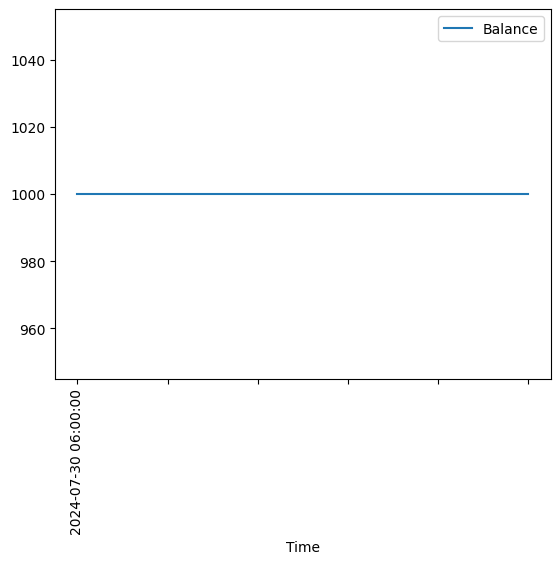

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 08:00:00


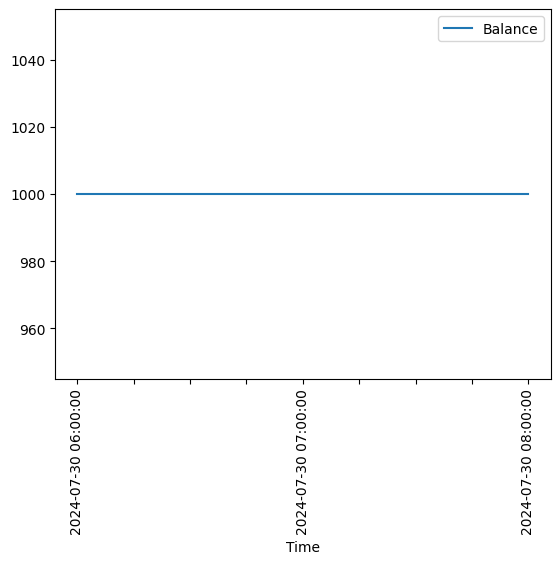

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-30 09:00:00


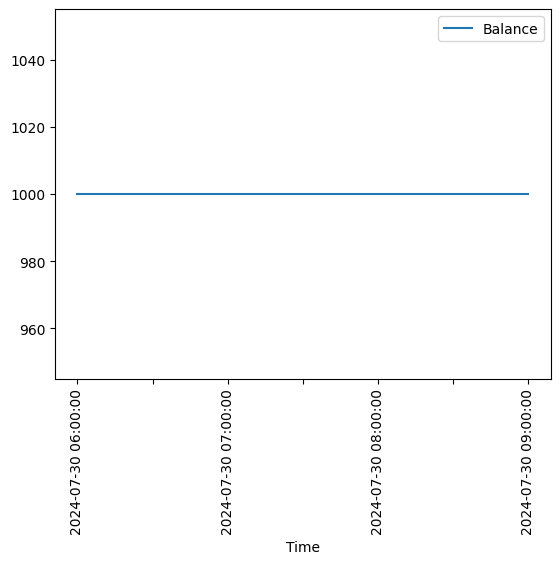

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 10:00:00


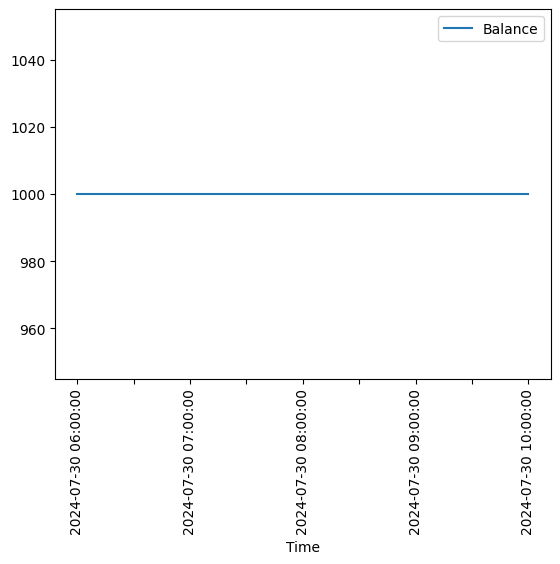

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 11:00:00


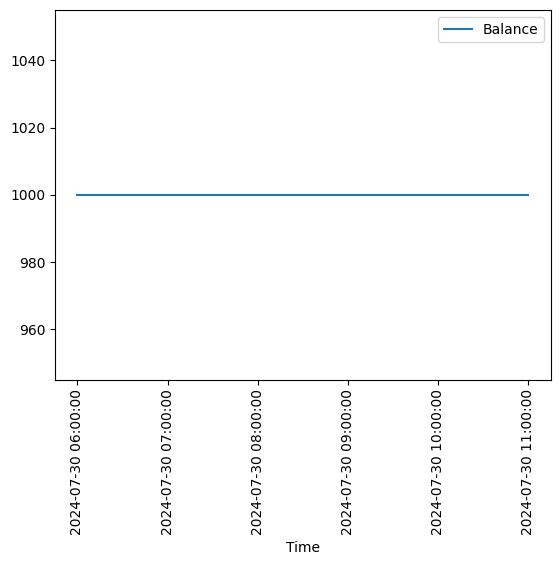

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 12:00:00


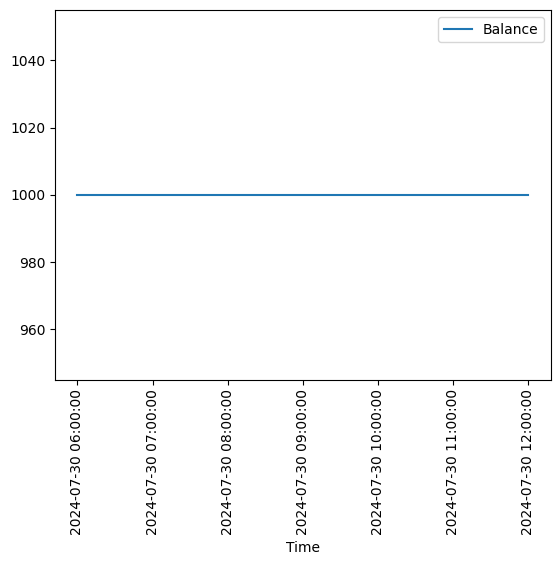

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 13:00:00


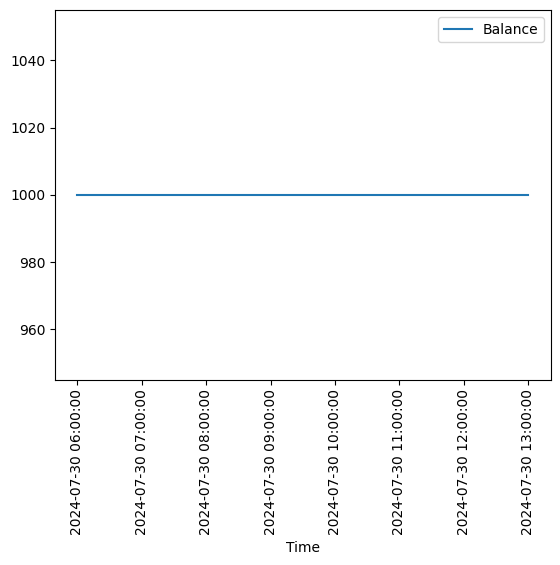

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 14:00:00


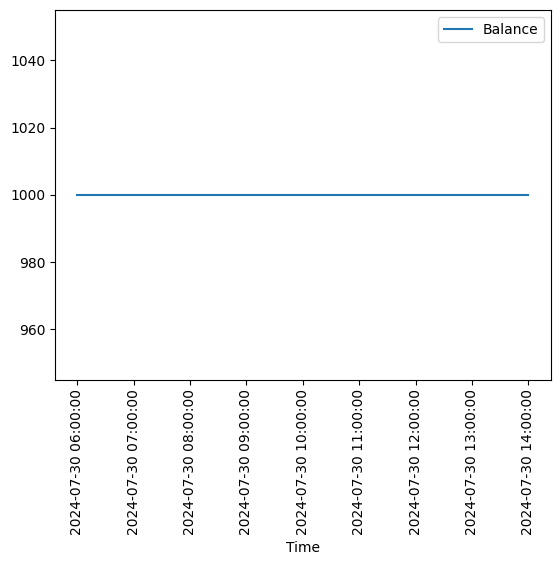

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 15:00:00


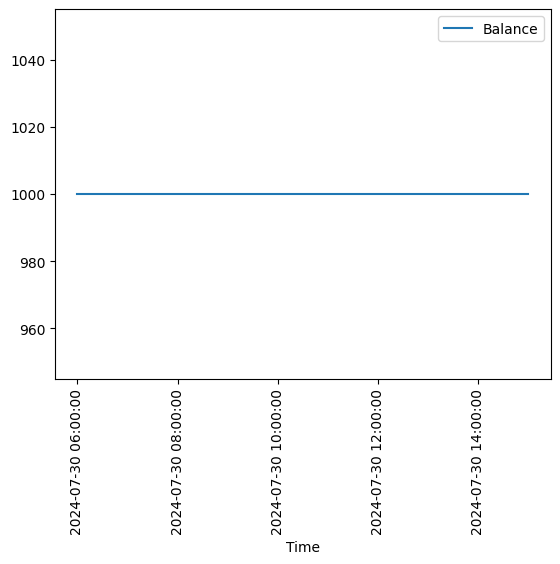

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 16:00:00


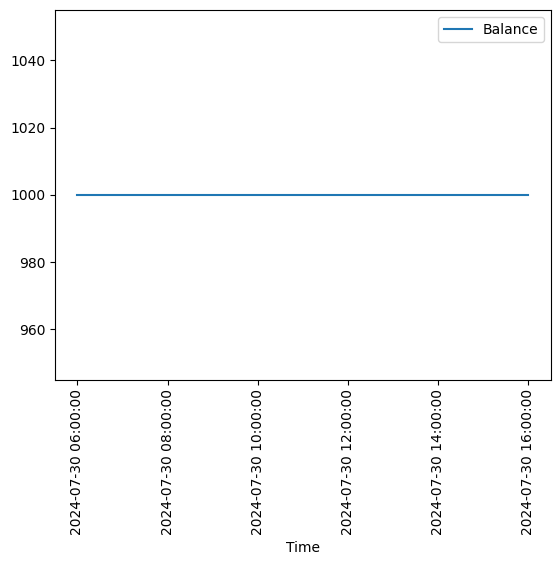

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-30 17:00:00


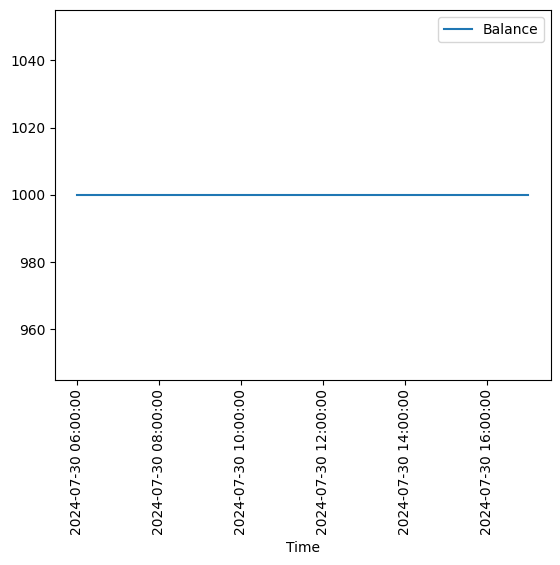

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 18:00:00


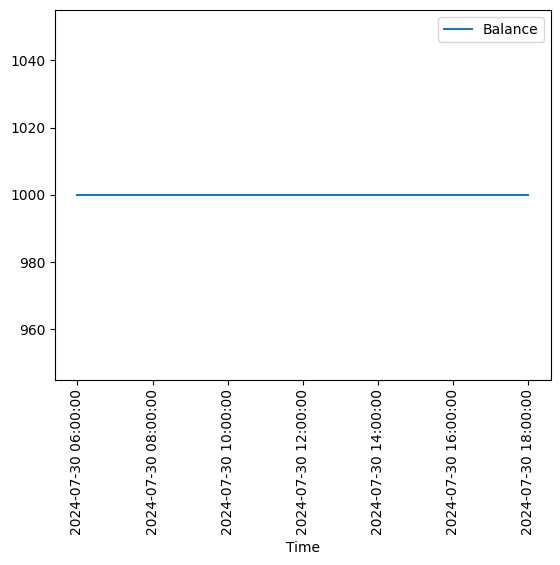

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 19:00:00


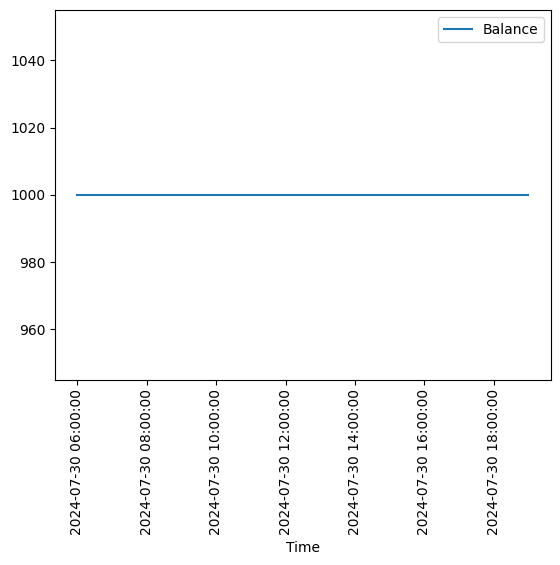

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 20:00:00


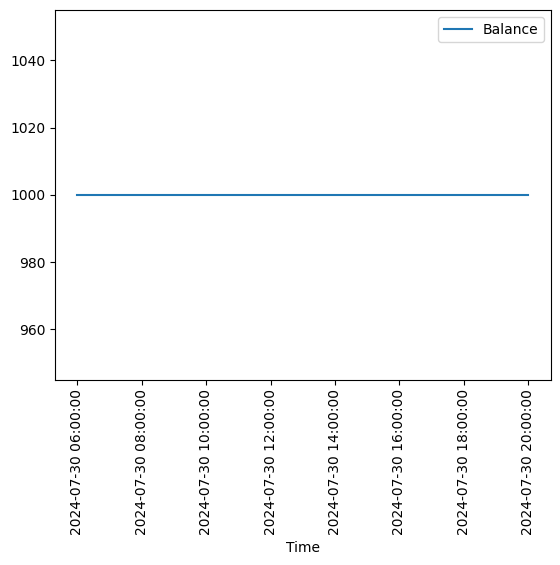

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-30 21:00:00


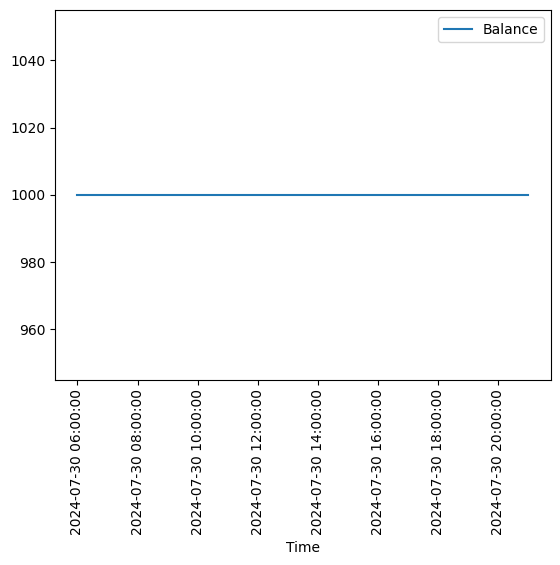

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 22:00:00


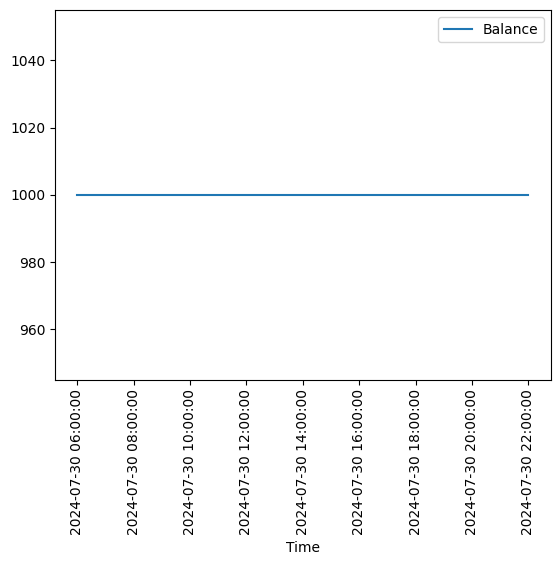

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-30 23:00:00


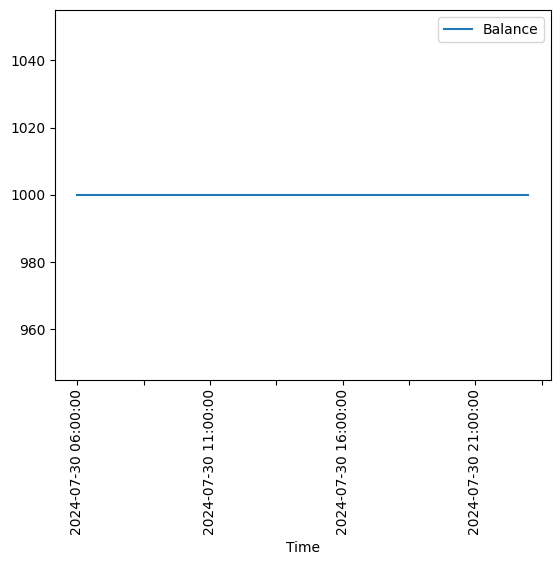

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 00:00:00


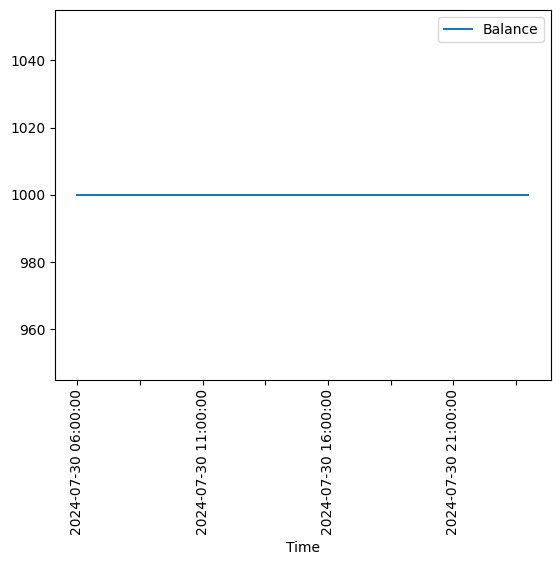

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 01:00:00


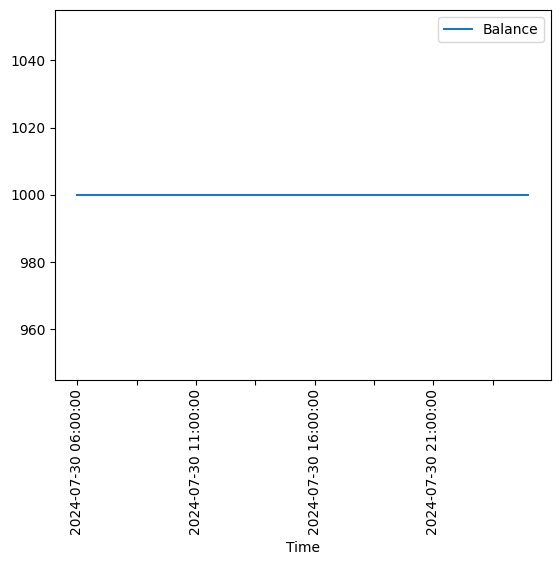

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 02:00:00


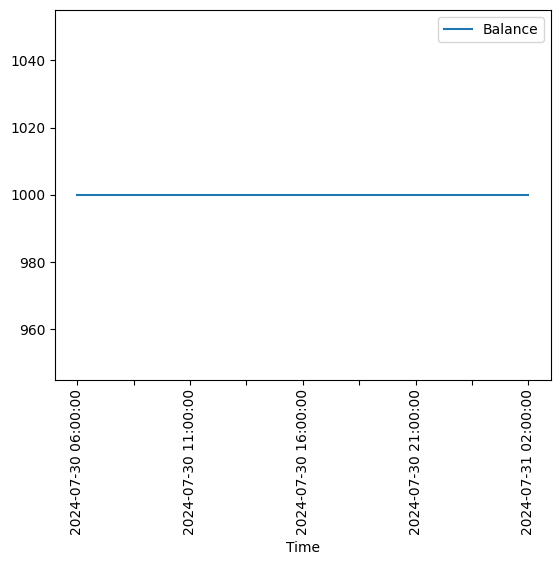

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 03:00:00


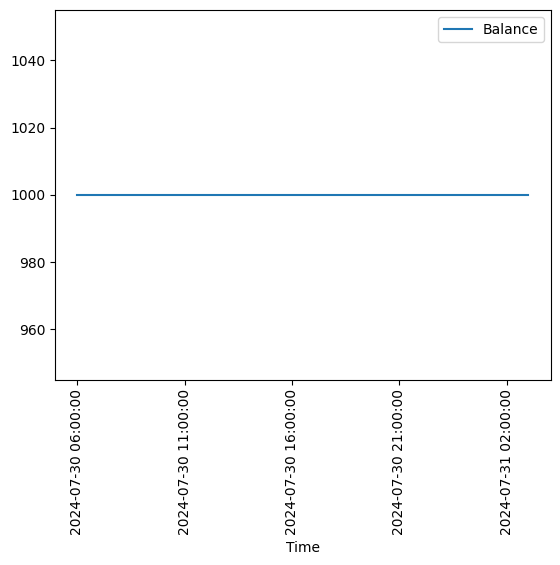

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 04:00:00


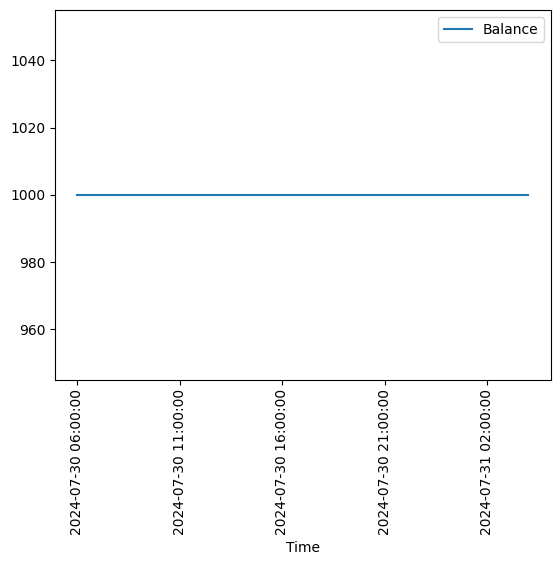

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 05:00:00


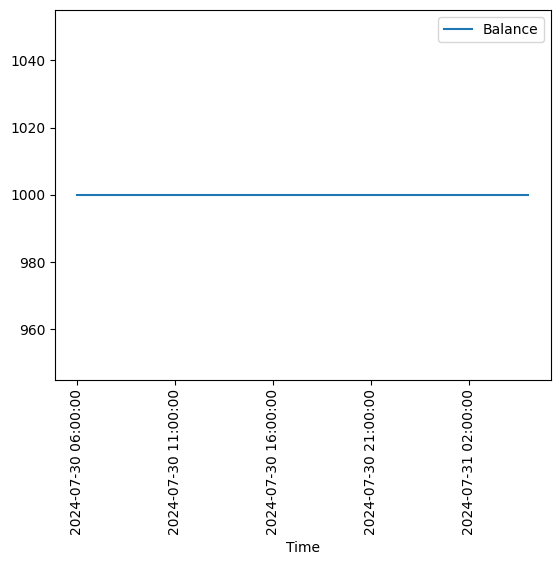

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 06:00:00


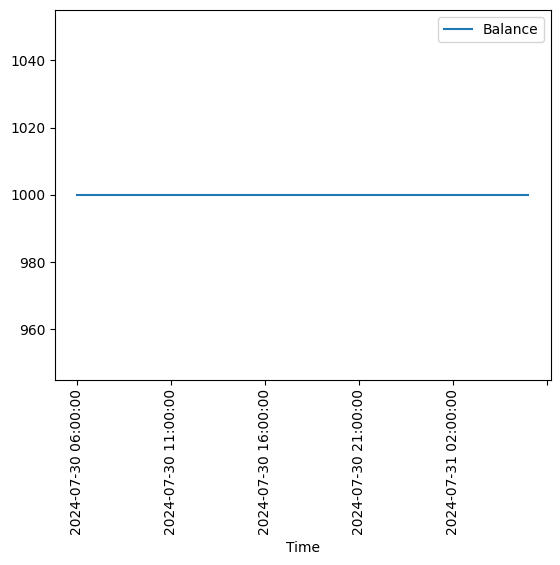

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 07:00:00


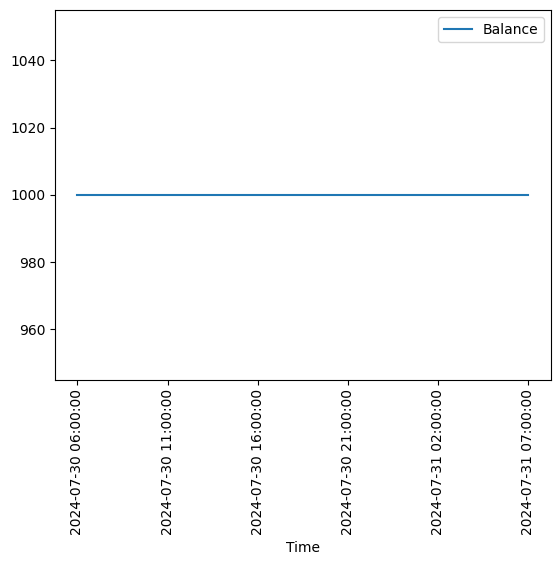

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 08:00:00


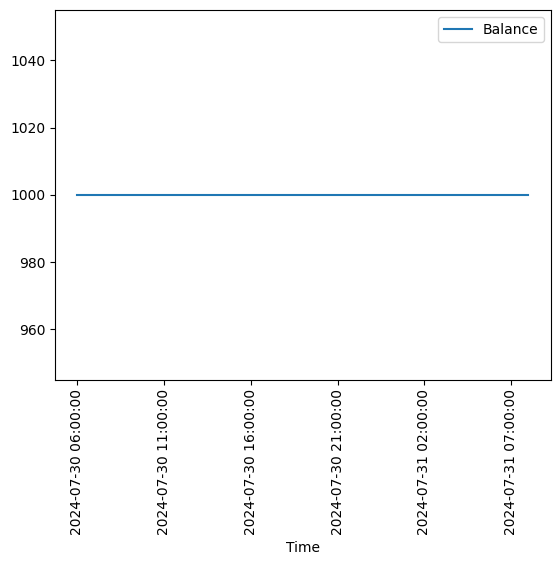

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 09:00:00


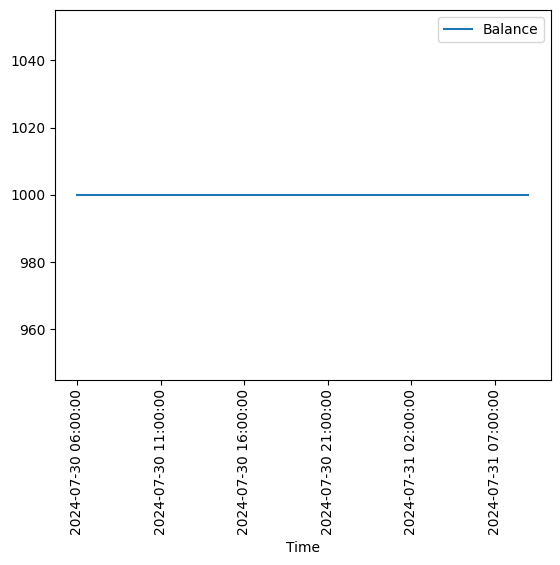

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 10:00:00


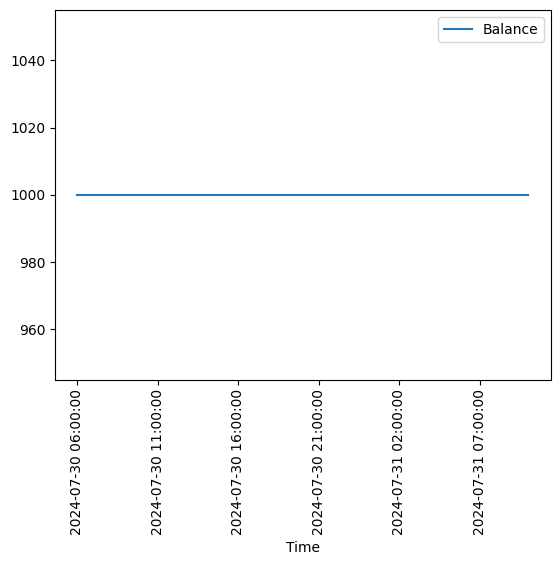

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-07-31 11:00:00


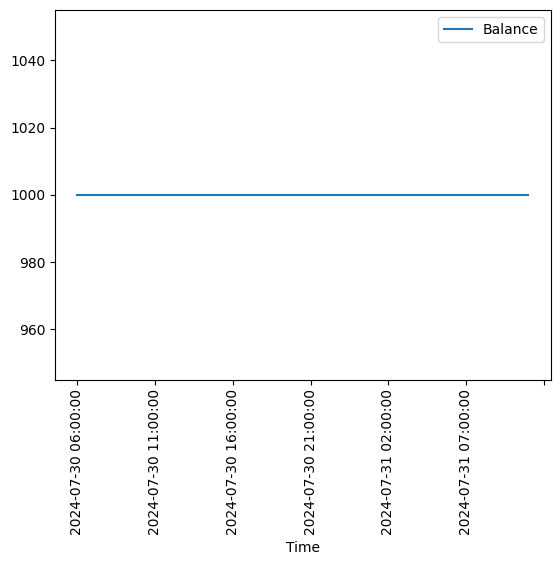

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 12:00:00


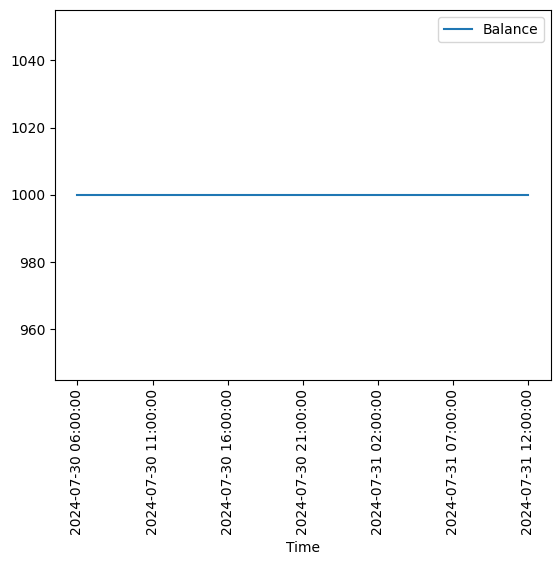

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 13:00:00


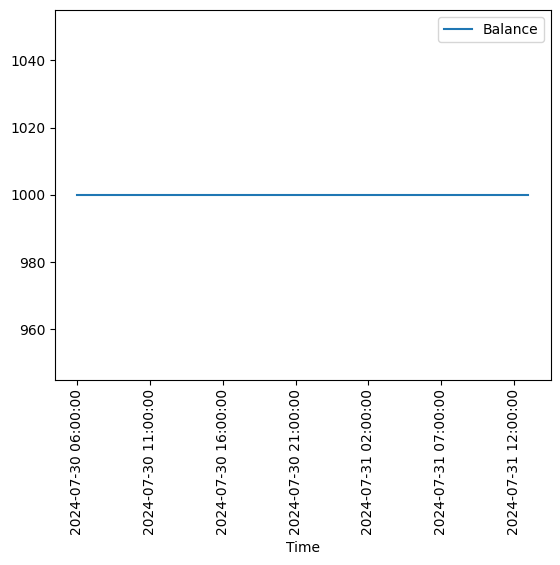

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 14:00:00


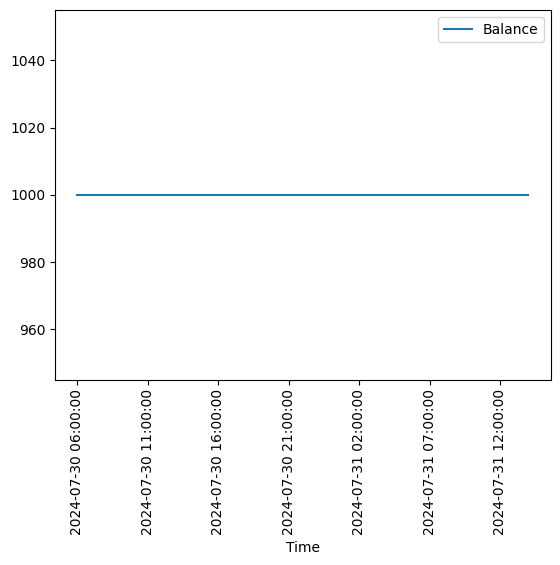

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 15:00:00


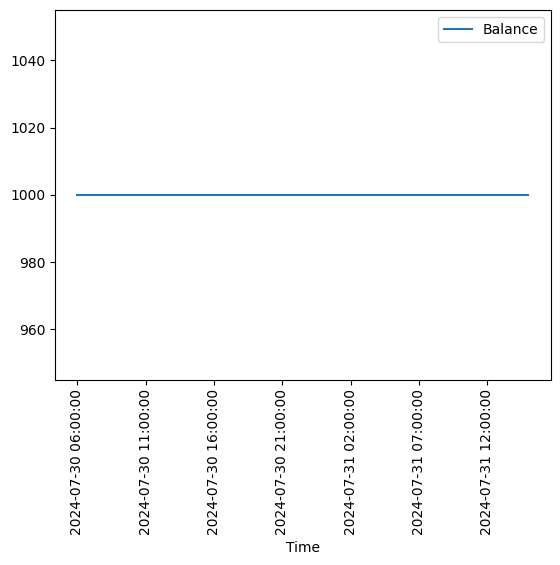

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 16:00:00


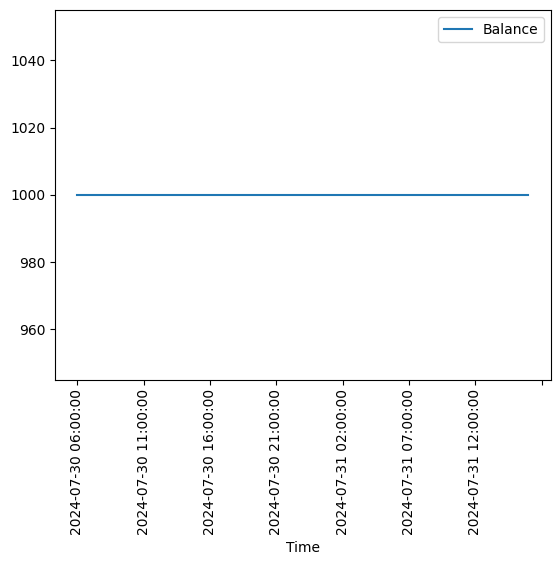

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 17:00:00


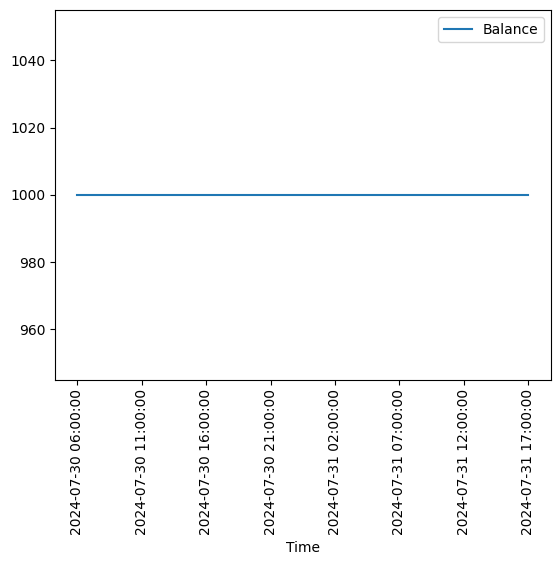

Concencus: 1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 18:00:00


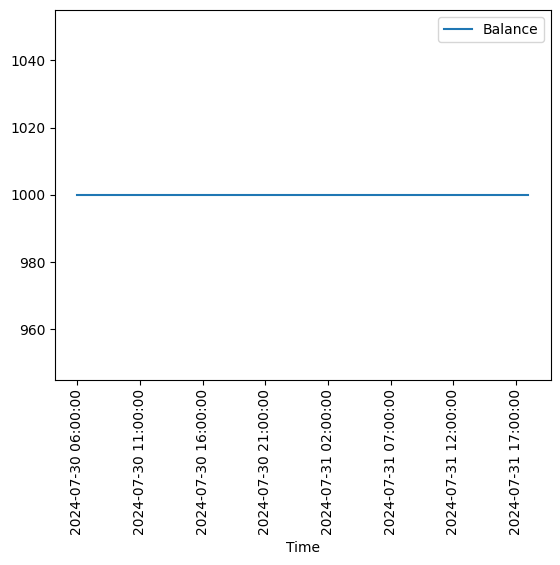

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 19:00:00


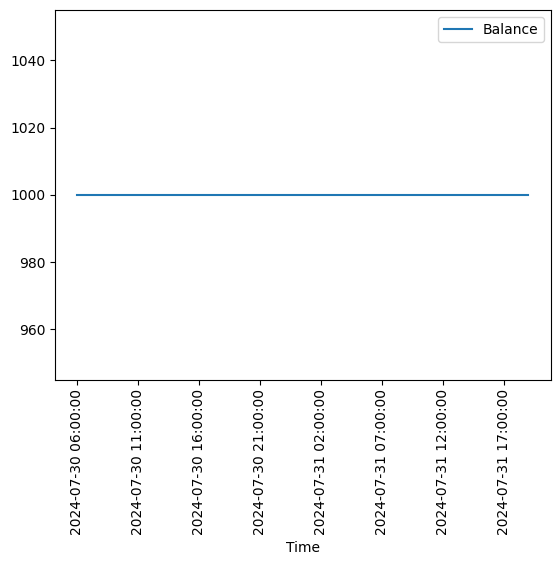

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 20:00:00


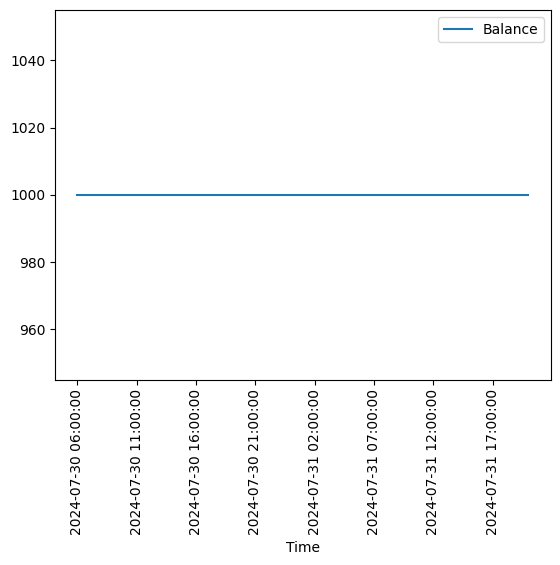

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 21:00:00


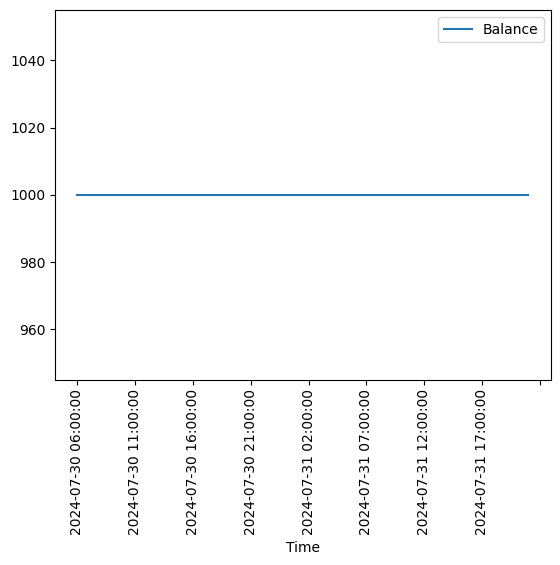

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-07-31 22:00:00


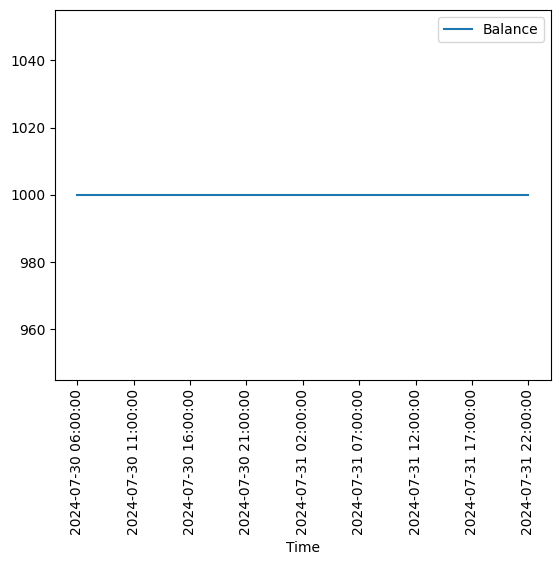

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-07-31 23:00:00


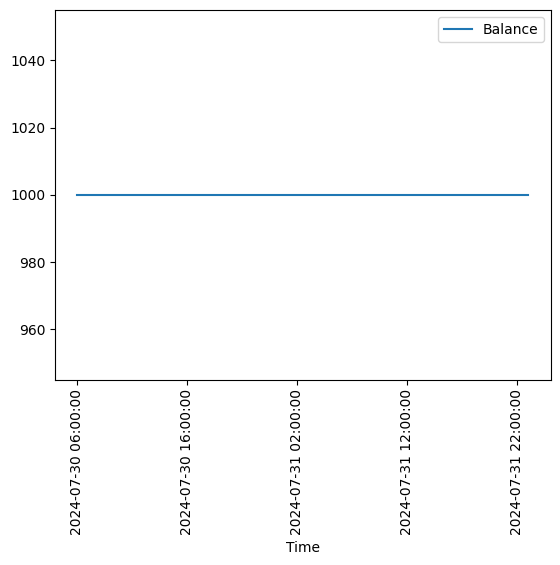

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 00:00:00


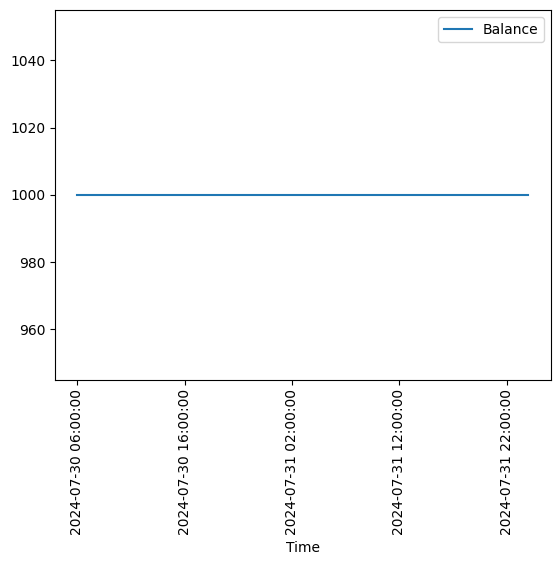

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 01:00:00


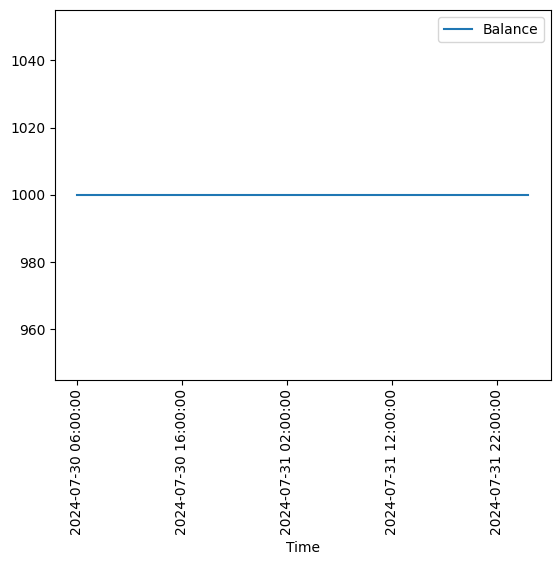

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 02:00:00


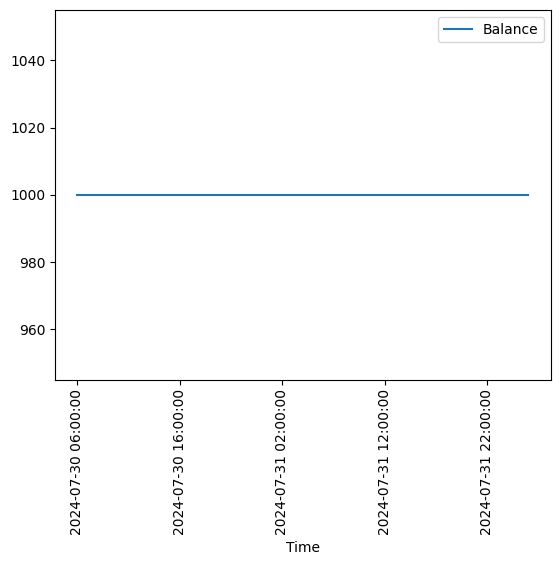

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 03:00:00


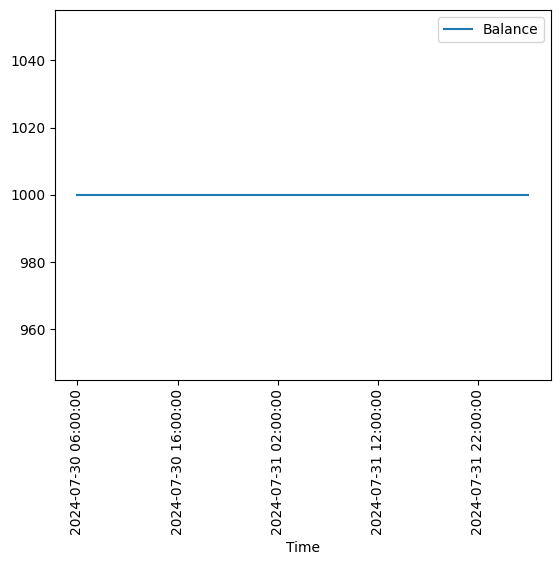

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 04:00:00


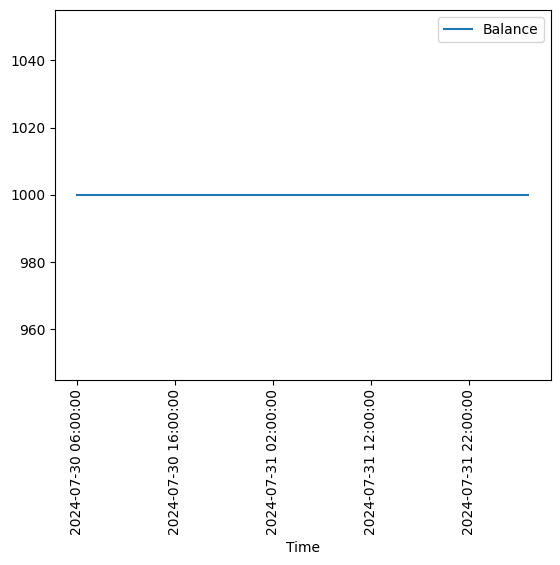

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 05:00:00


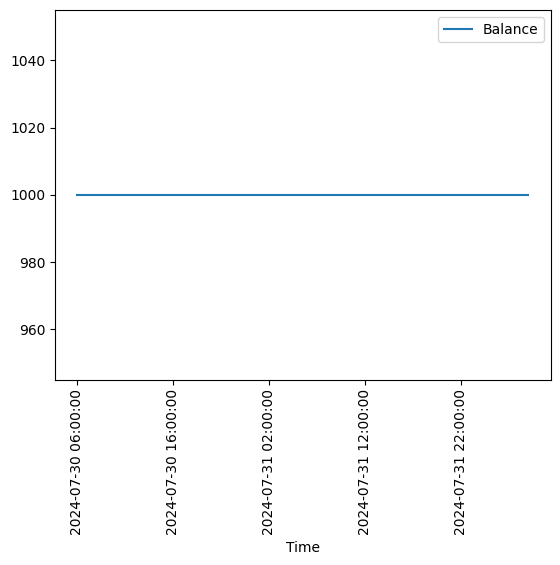

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 06:00:00


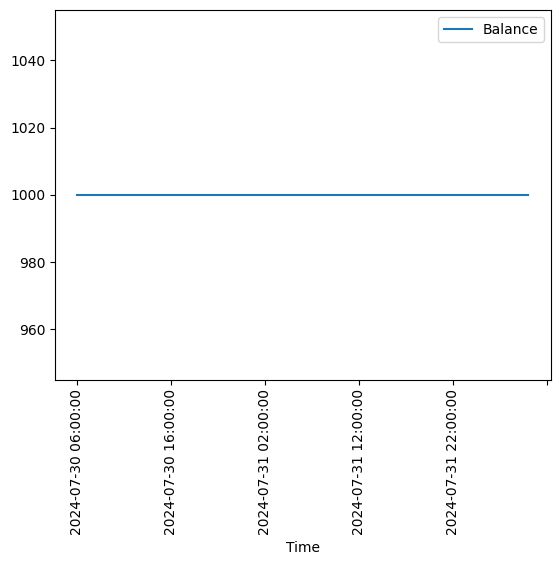

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 07:00:00


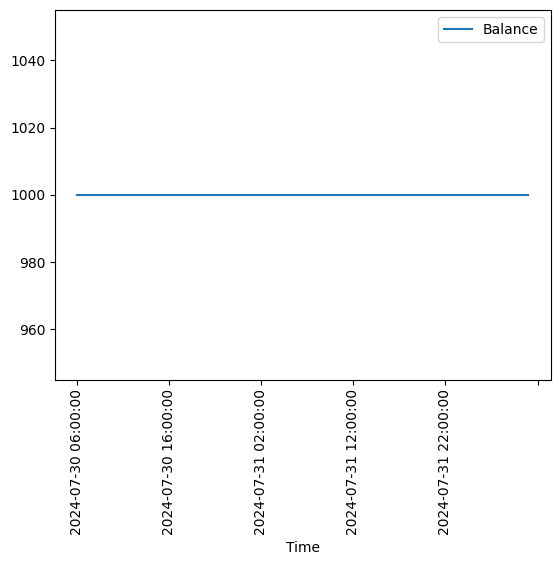

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 08:00:00


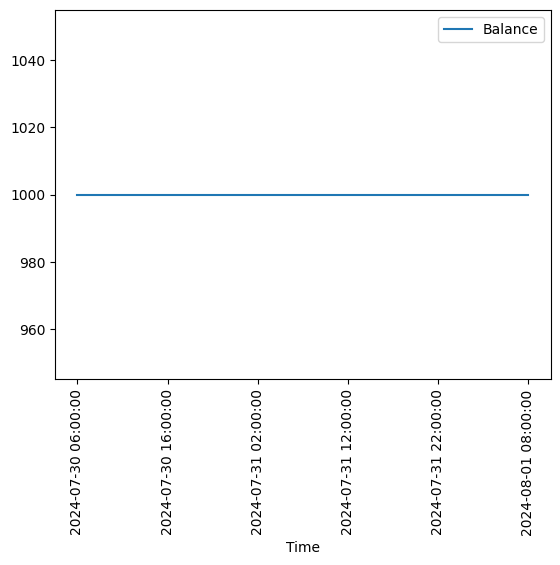

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 09:00:00


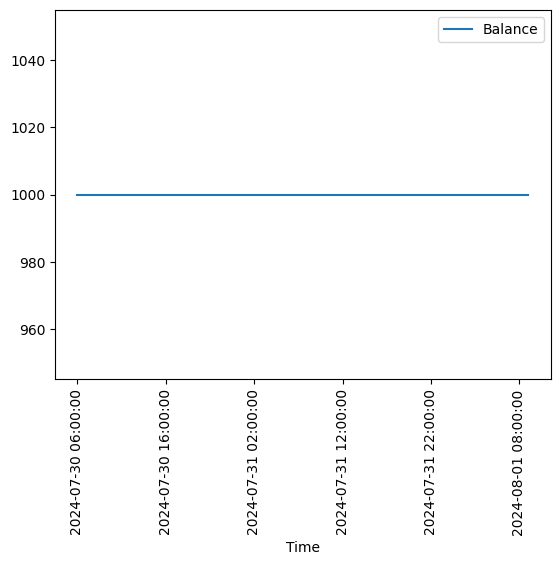

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 10:00:00


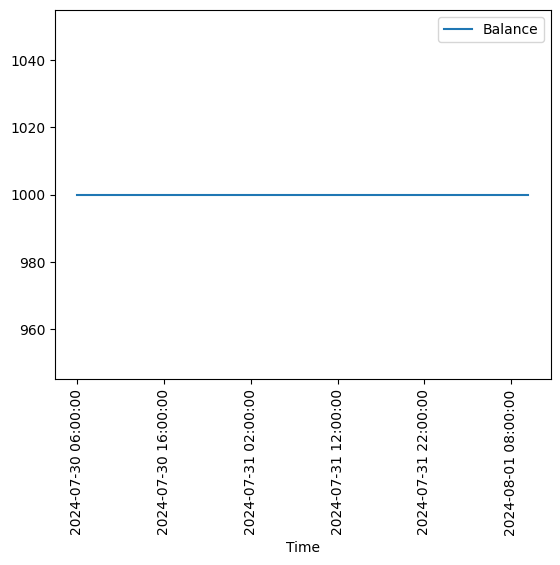

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 11:00:00


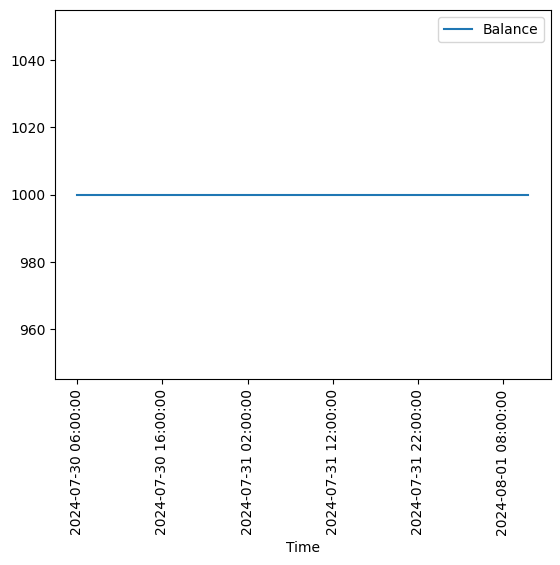

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 12:00:00


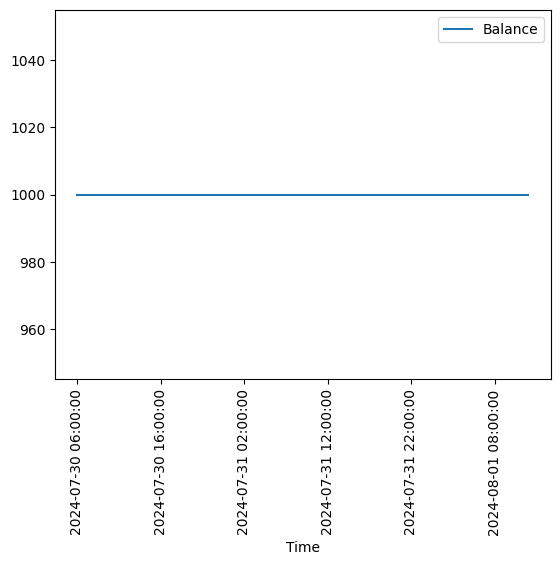

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 13:00:00


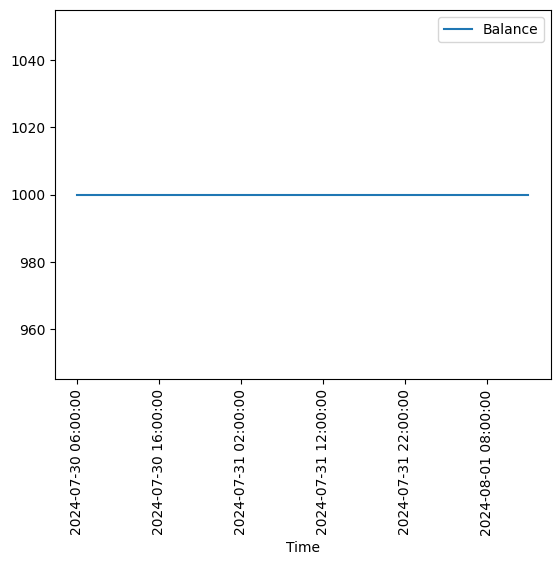

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 14:00:00


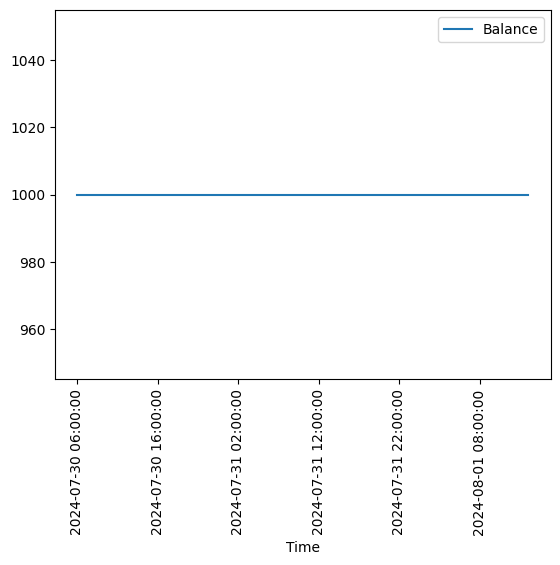

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 15:00:00


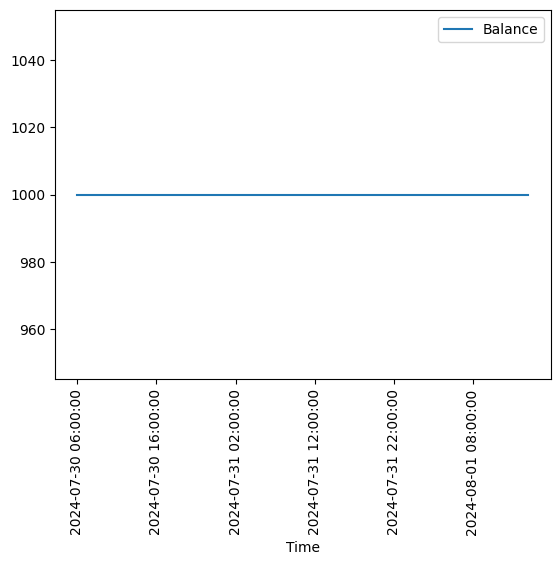

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 16:00:00


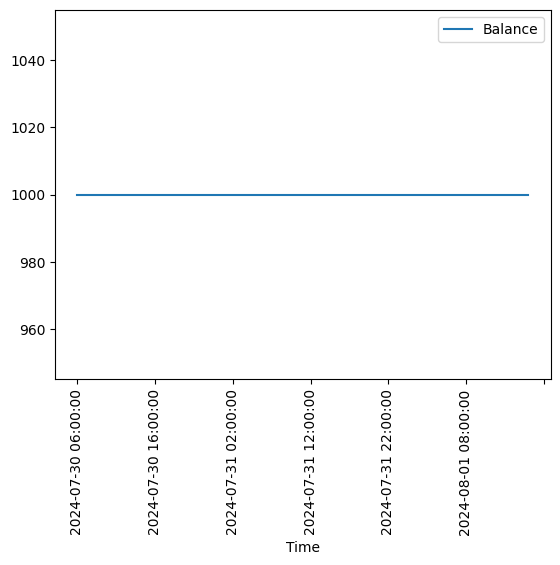

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 17:00:00


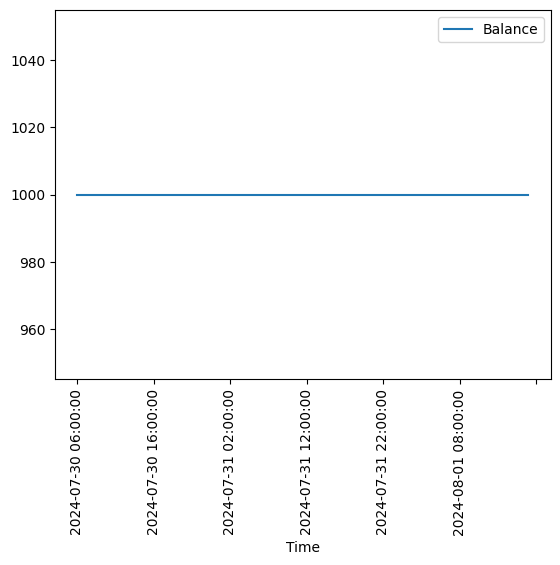

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 18:00:00


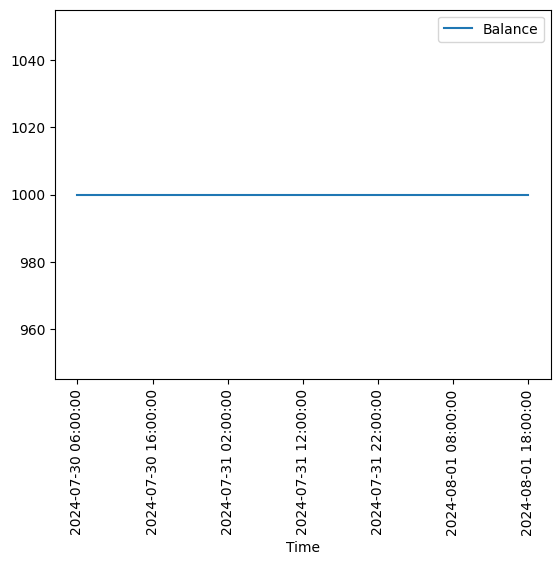

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 19:00:00


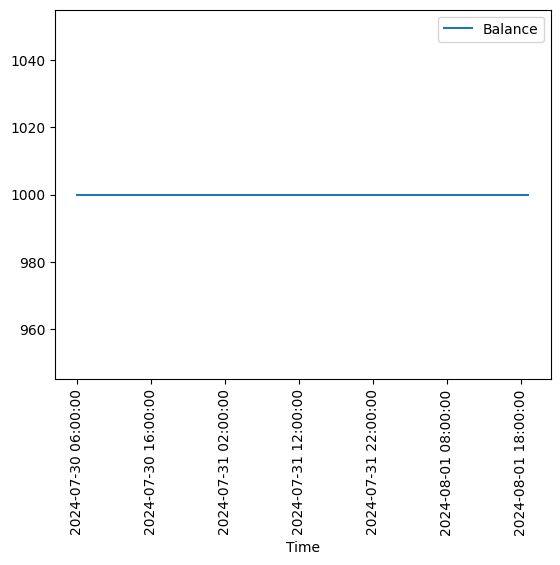

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-01 20:00:00


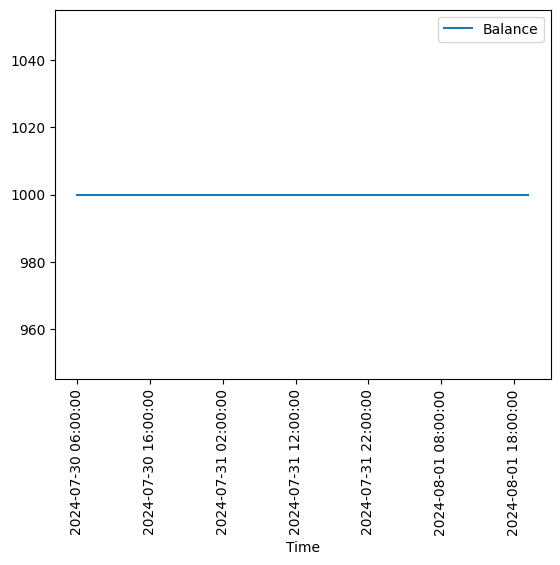

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-01 21:00:00


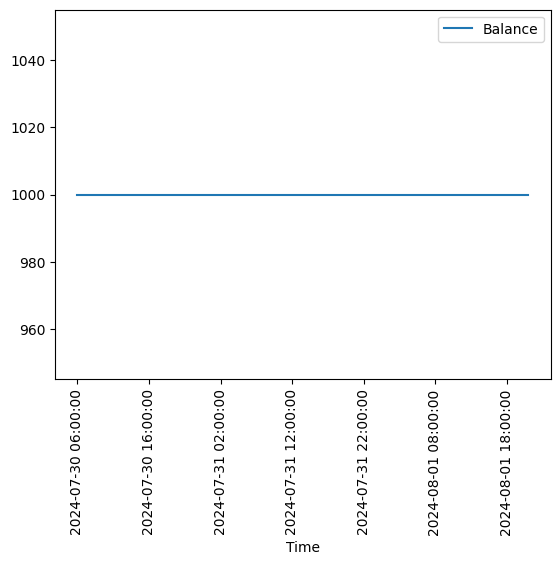

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-01 22:00:00


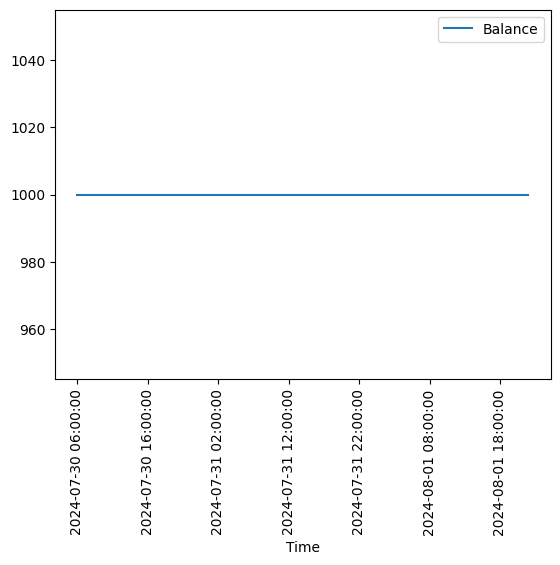

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-01 23:00:00


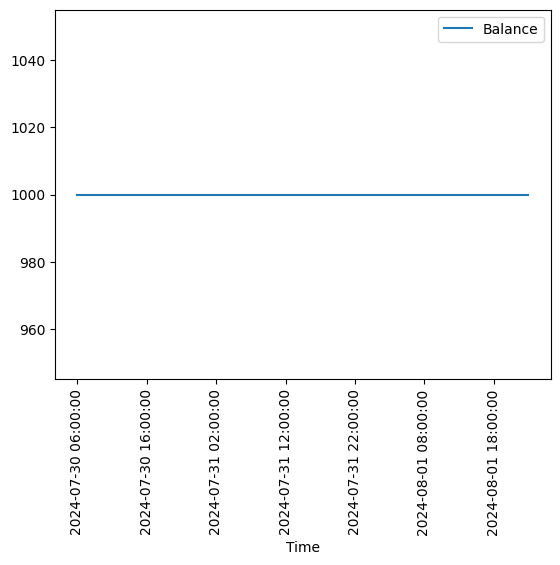

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 00:00:00


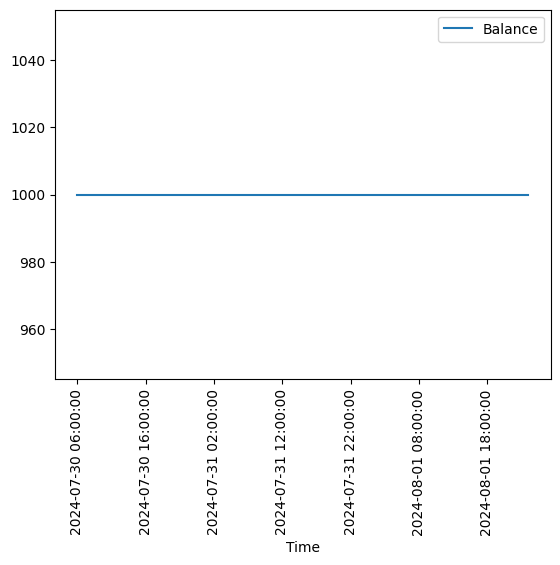

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 01:00:00


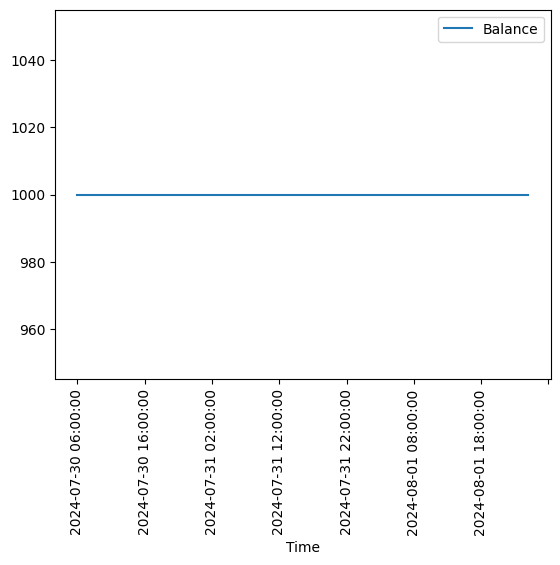

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 02:00:00


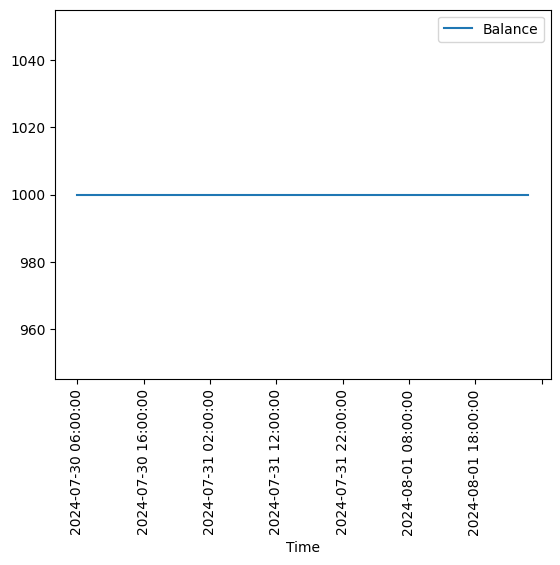

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-02 03:00:00


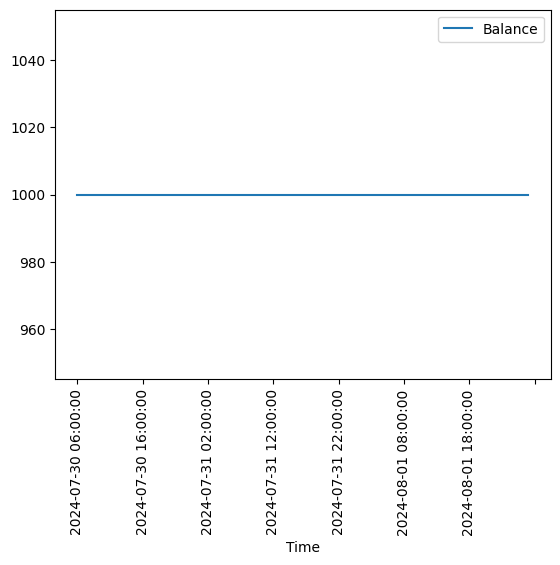

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-02 04:00:00


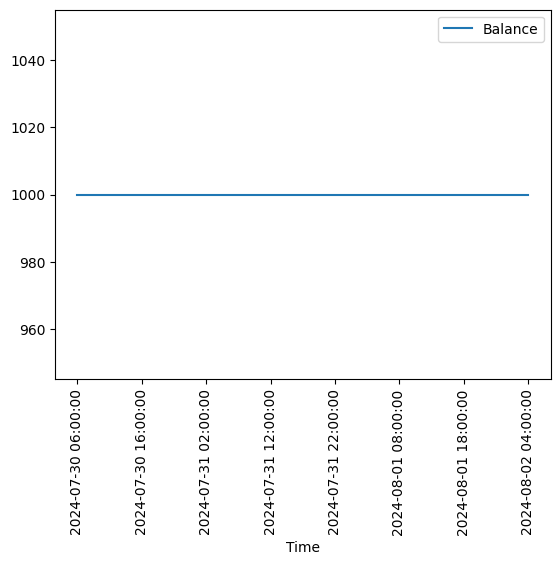

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-02 05:00:00


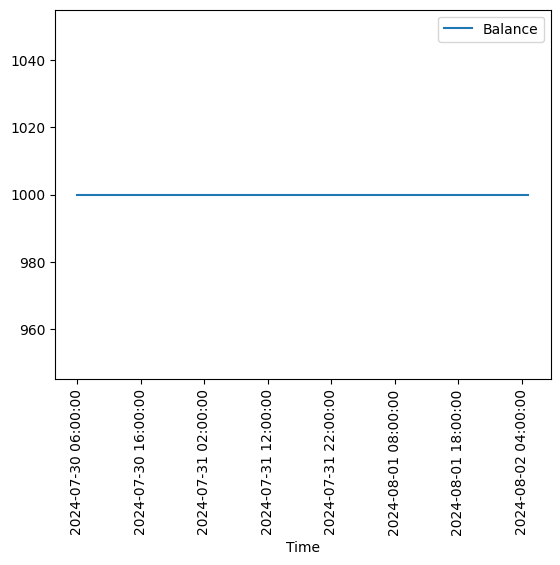

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-02 06:00:00


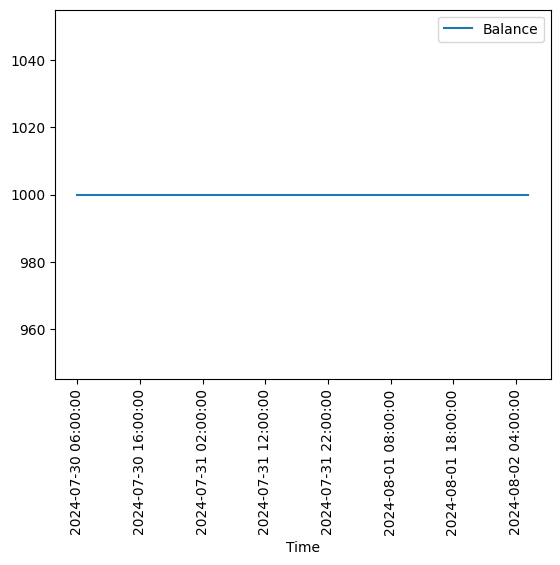

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-02 07:00:00


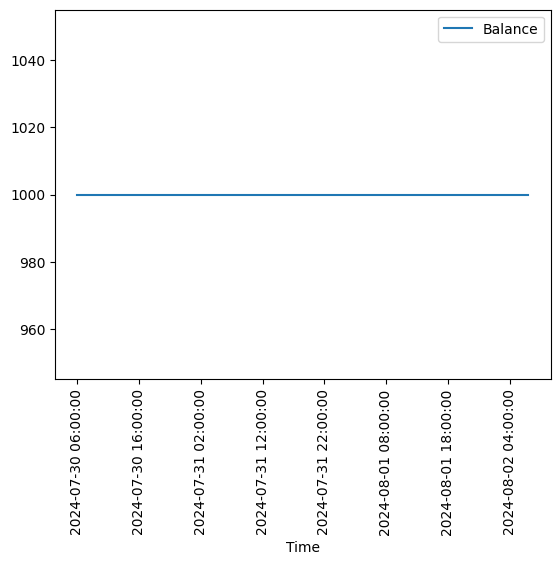

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-02 08:00:00


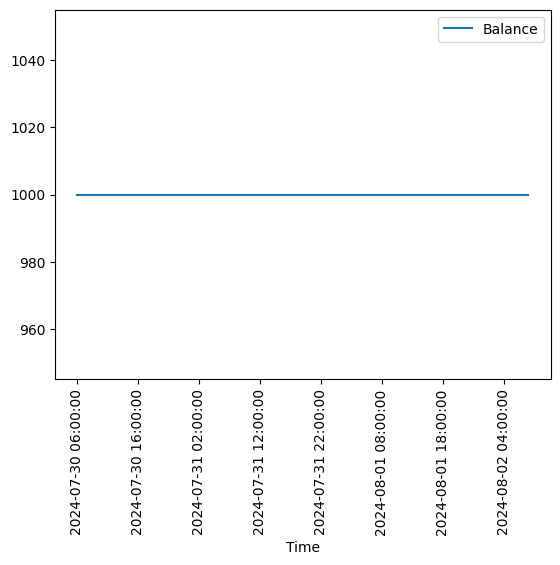

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 09:00:00


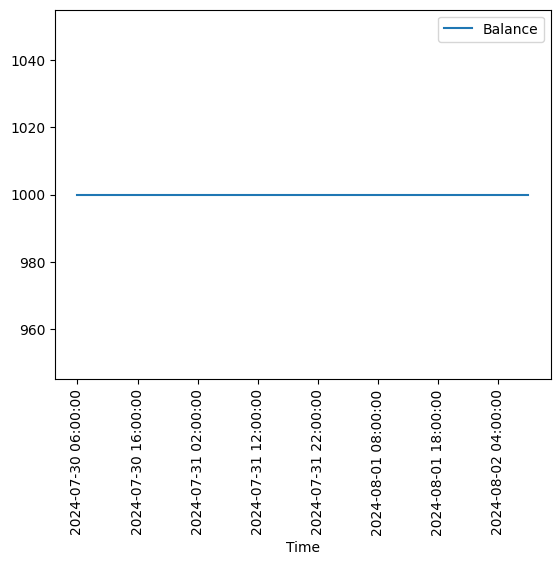

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 10:00:00


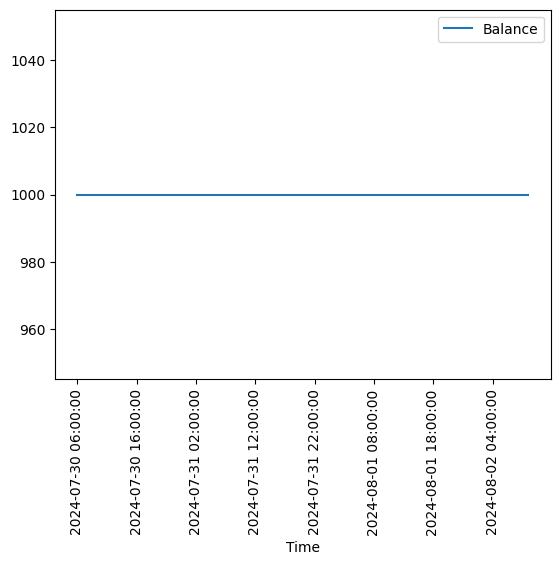

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 11:00:00


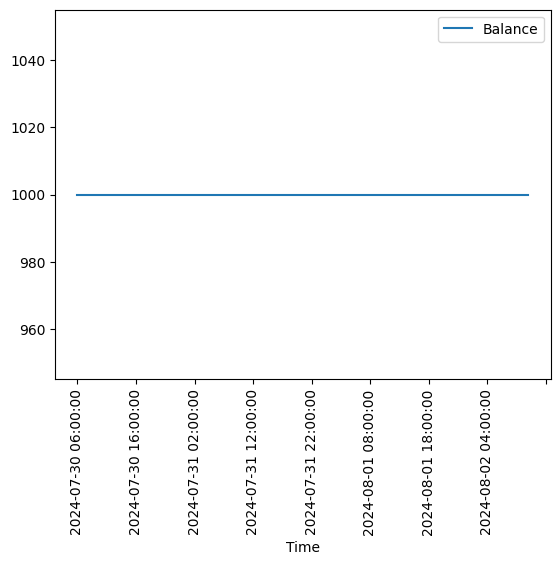

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 12:00:00


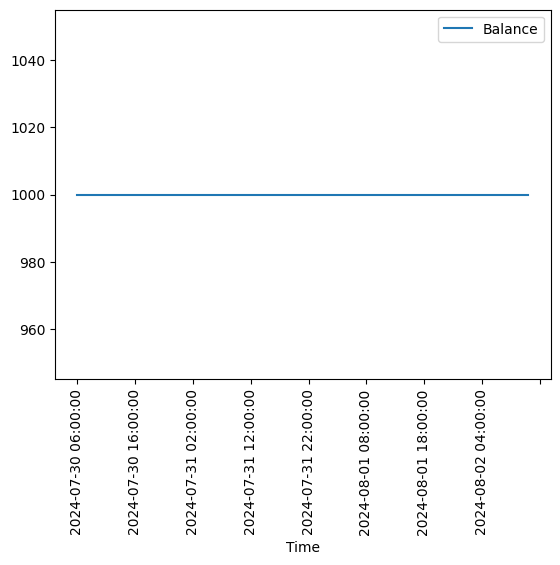

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 13:00:00


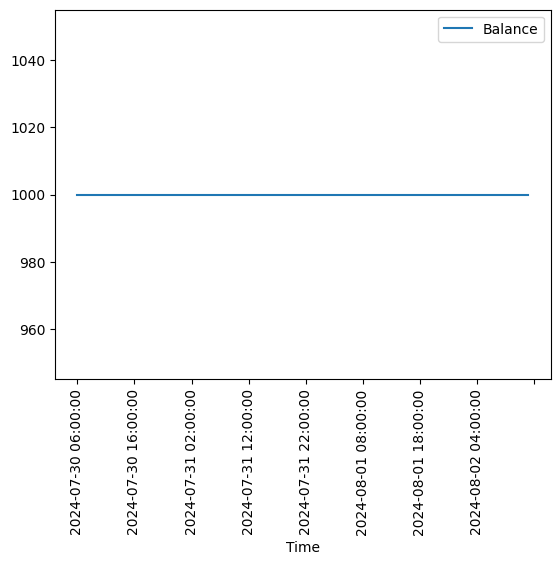

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 14:00:00


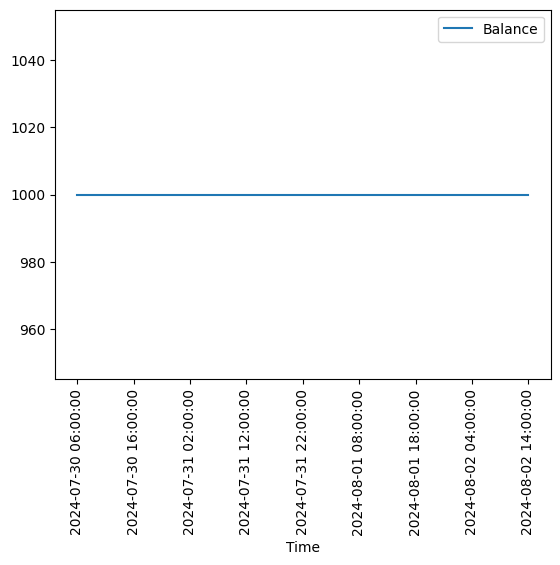

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 15:00:00


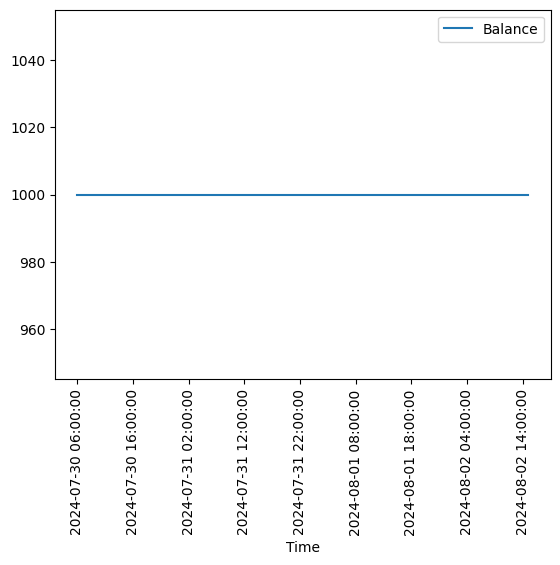

Concencus: 0
Current Balance: 1000 USD and 0 BTC at 2024-08-02 16:00:00


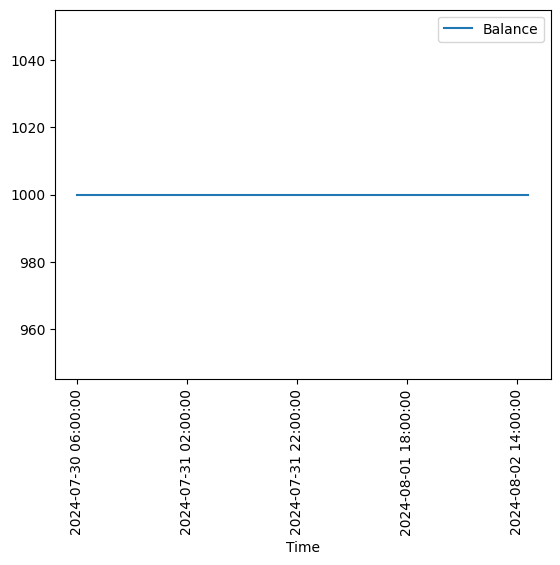

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 17:00:00


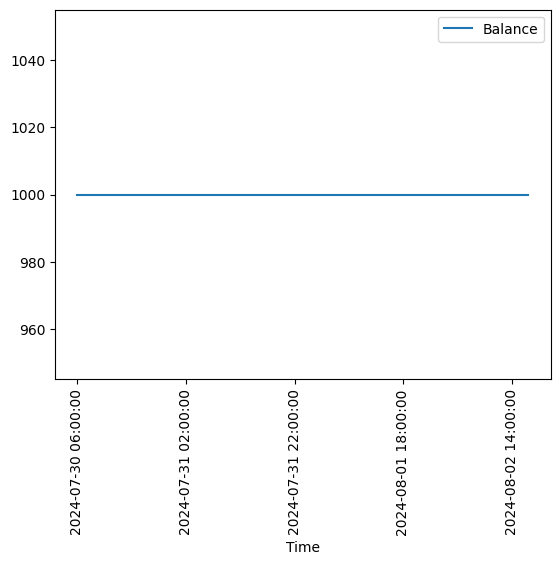

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 18:00:00


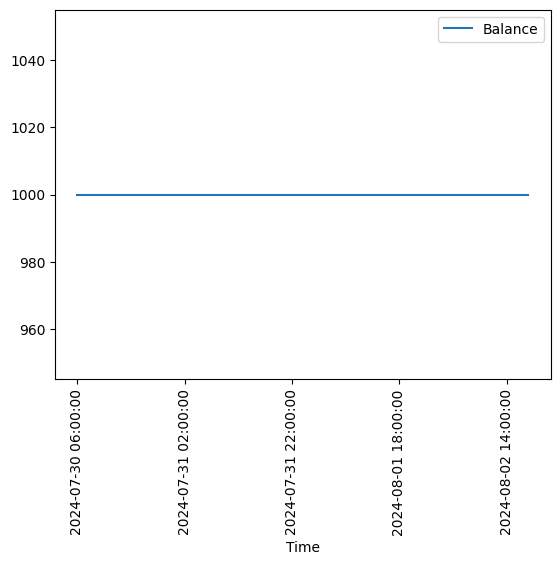

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 19:00:00


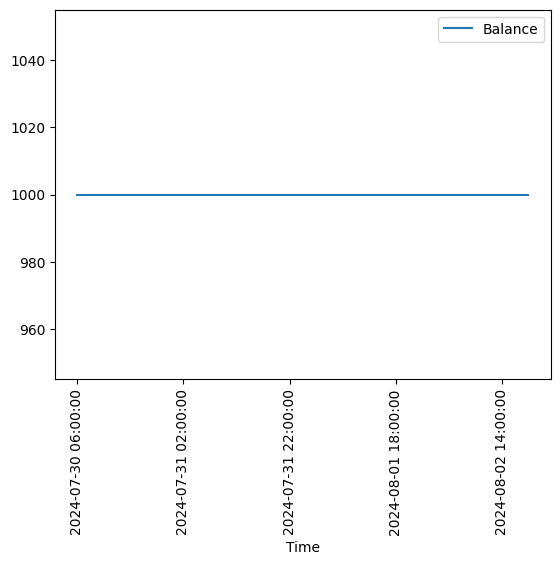

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 20:00:00


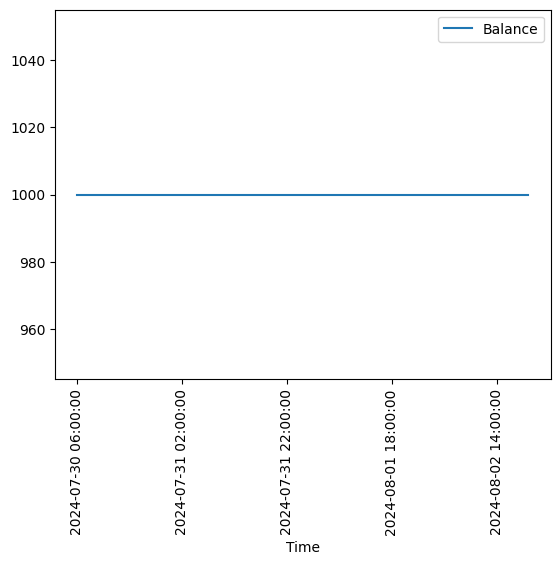

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 21:00:00


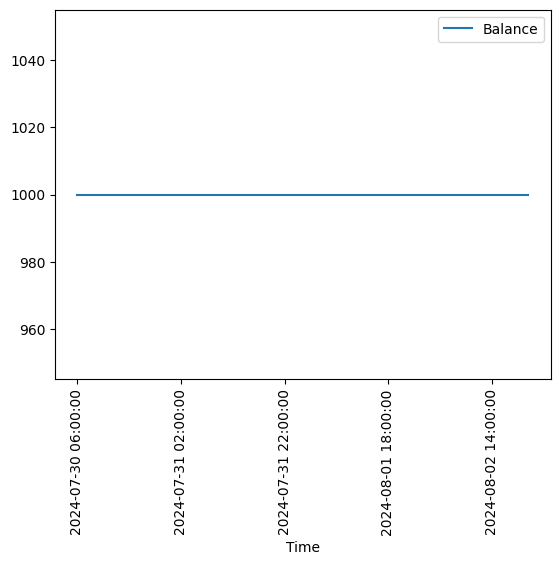

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 22:00:00


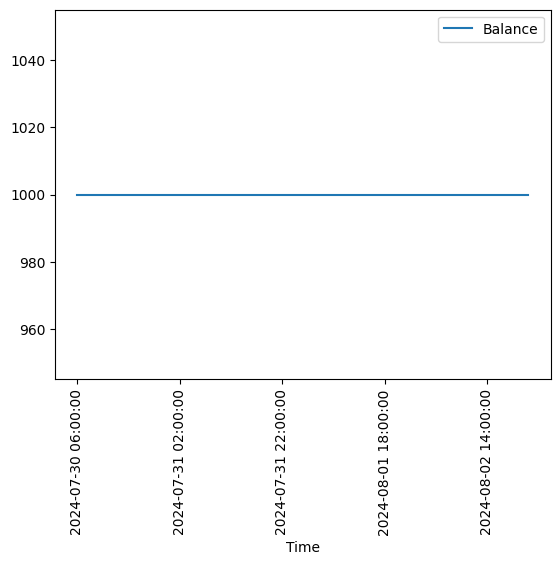

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-02 23:00:00


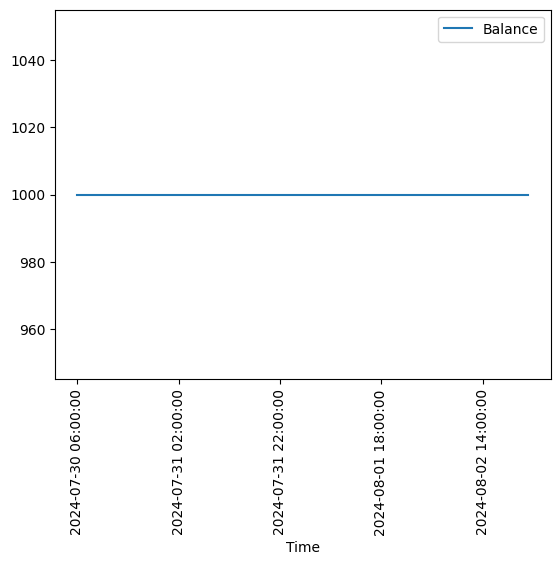

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 00:00:00


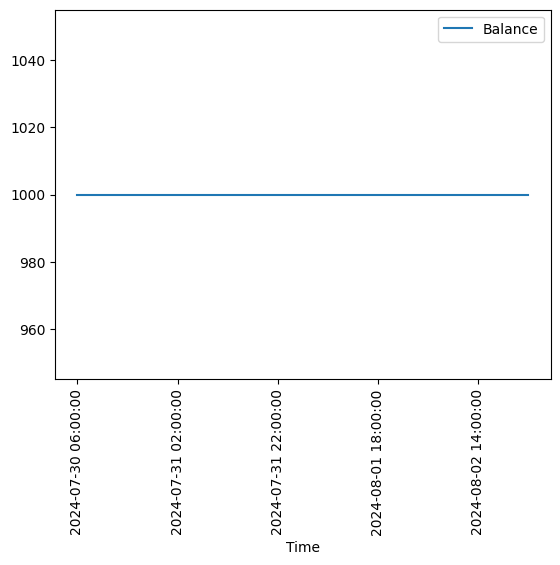

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 01:00:00


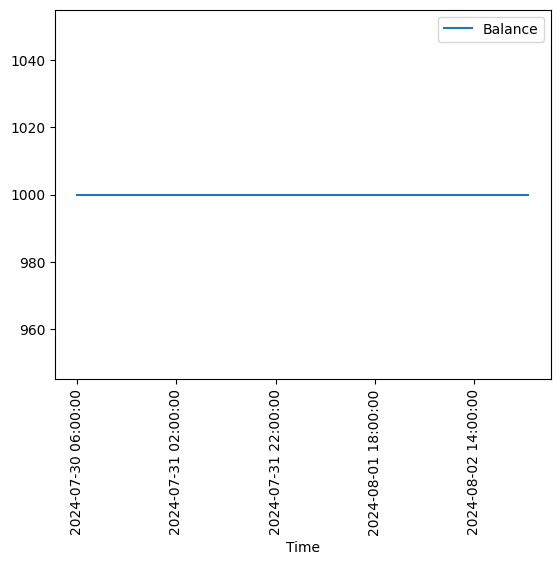

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 02:00:00


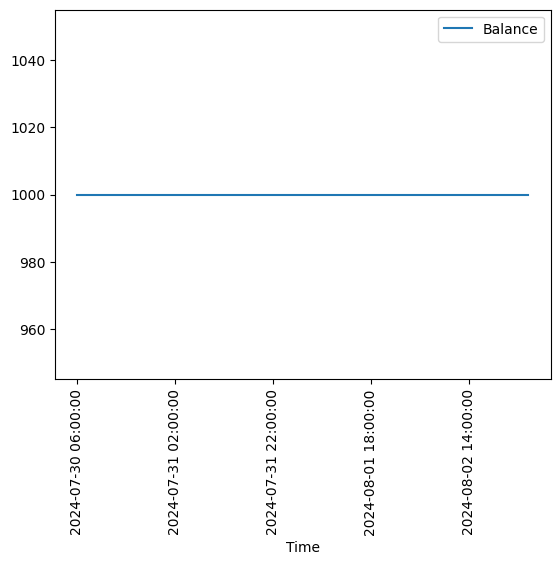

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-03 03:00:00


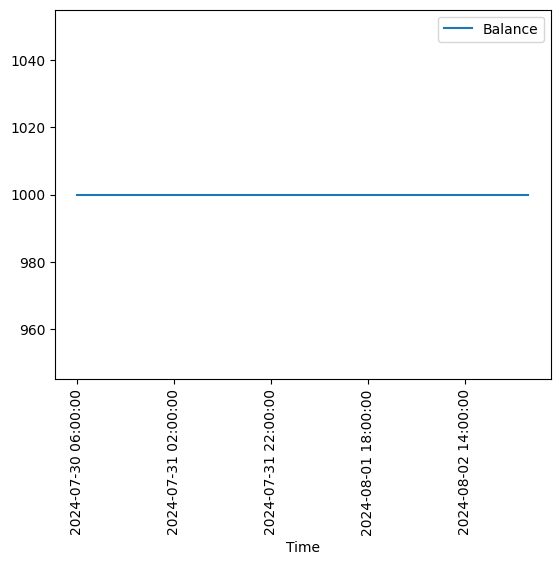

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 04:00:00


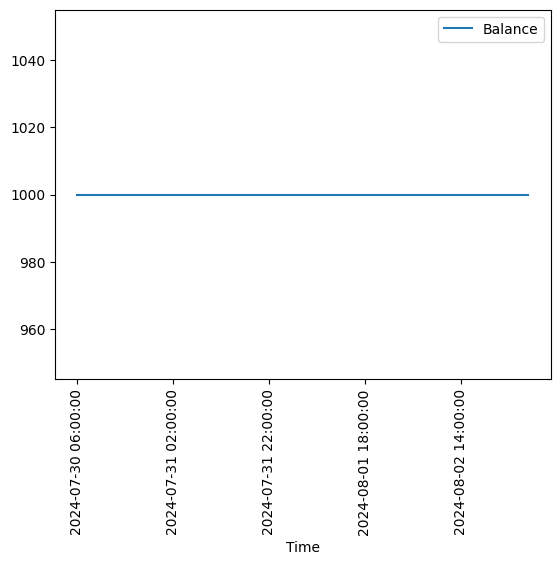

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 05:00:00


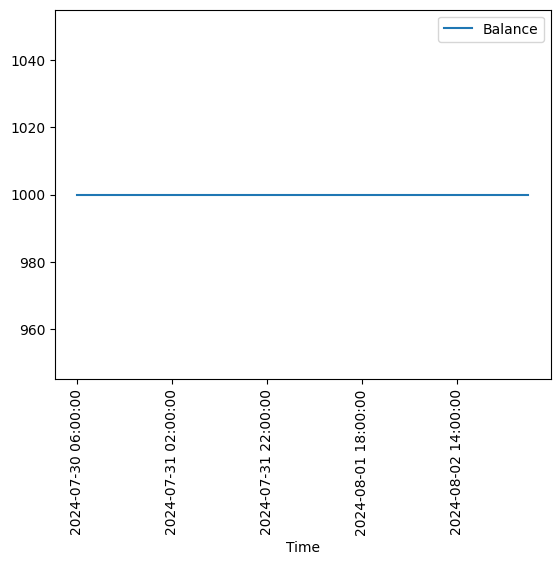

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 06:00:00


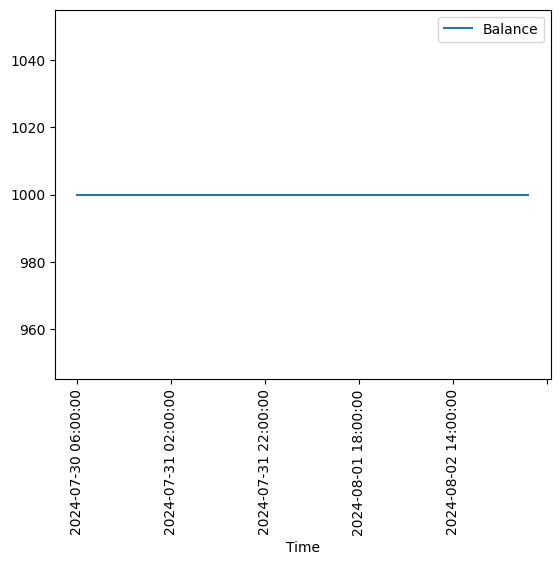

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 07:00:00


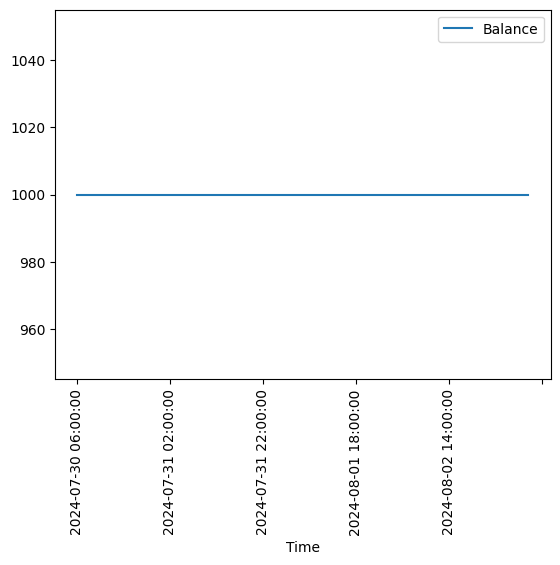

Concencus: -1
Current Balance: 1000 USD and 0 BTC at 2024-08-03 08:00:00


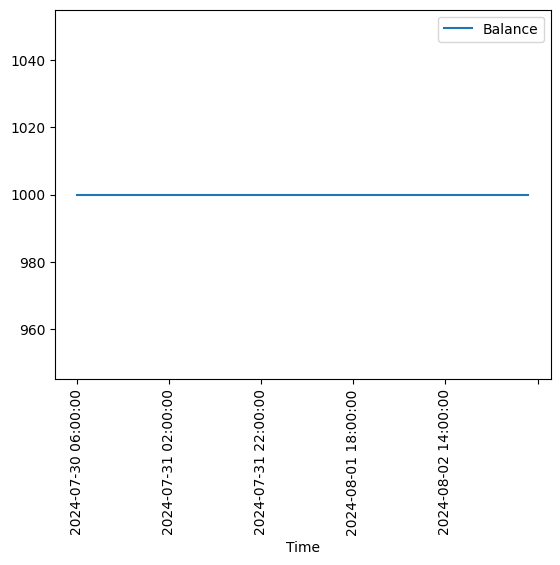

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 09:00:00


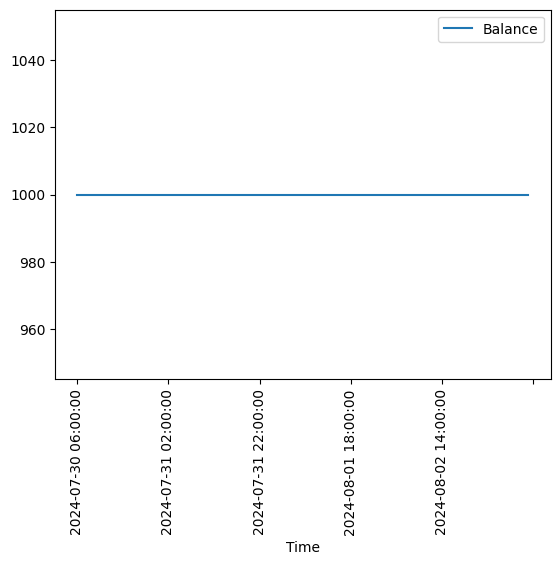

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 10:00:00


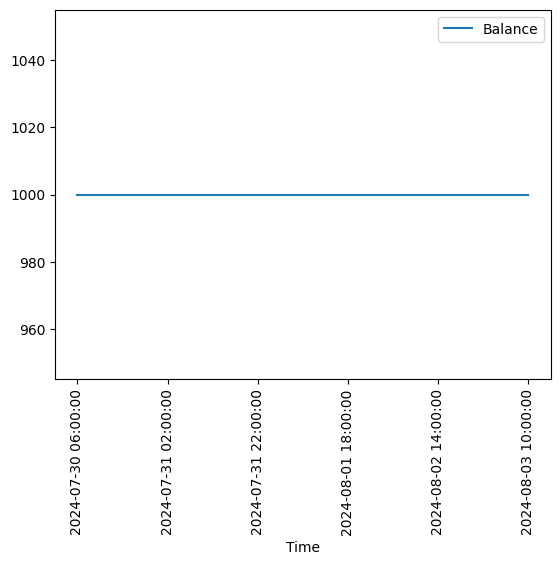

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 11:00:00


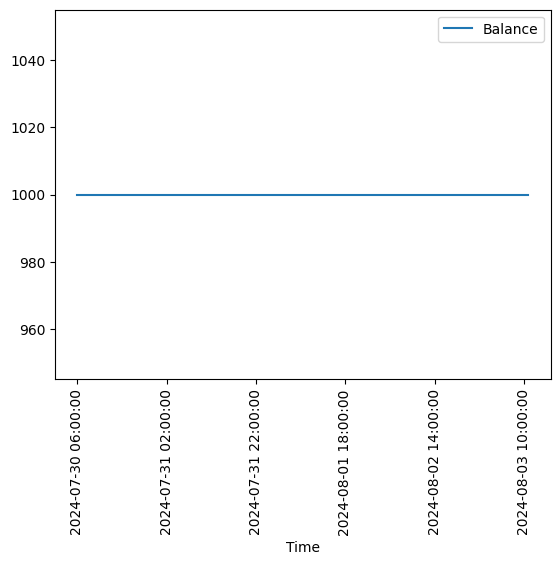

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 12:00:00


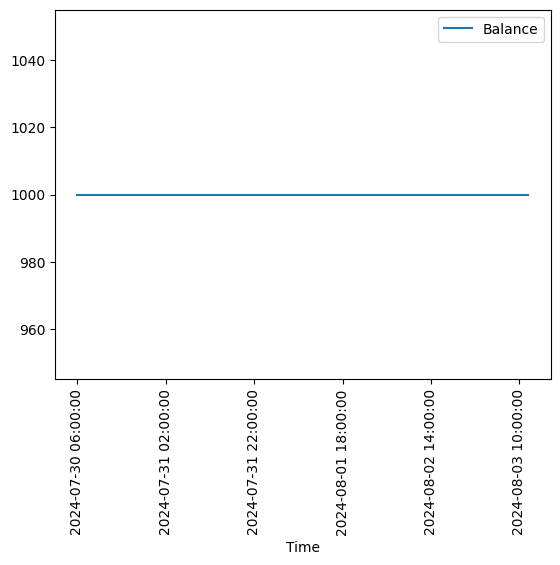

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 13:00:00


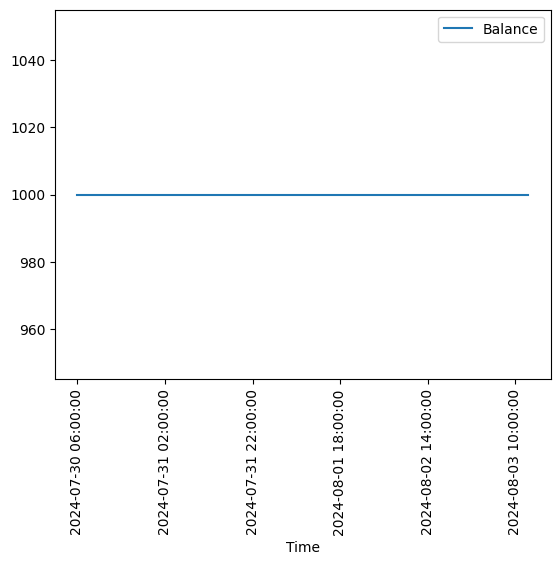

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 14:00:00


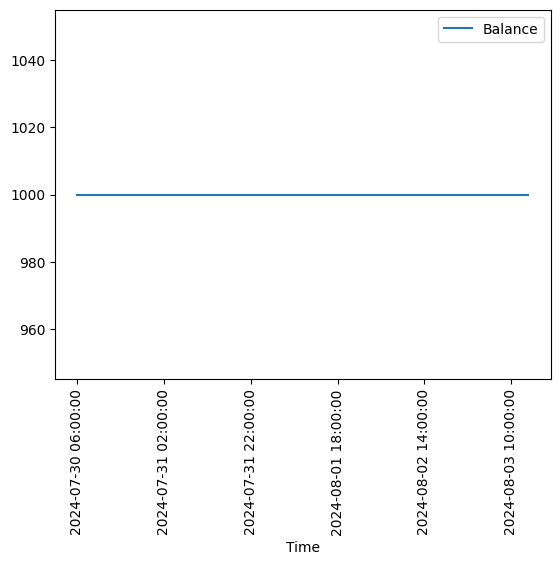

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 15:00:00


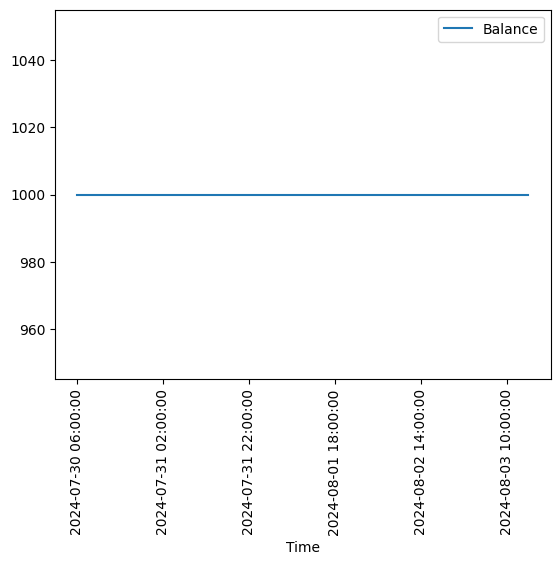

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 16:00:00


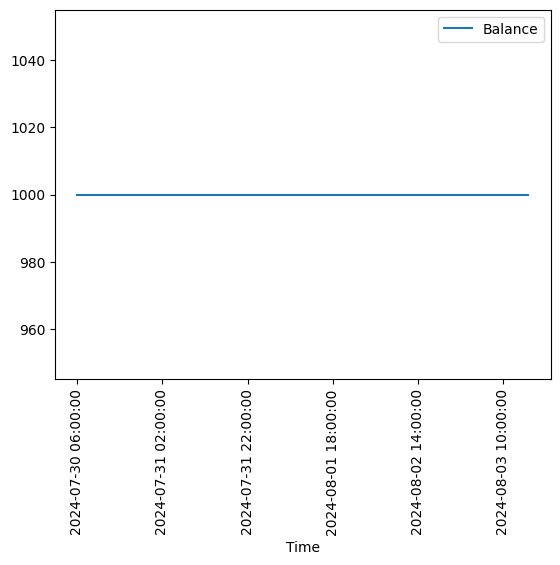

Concencus: -2
Current Balance: 1000 USD and 0 BTC at 2024-08-03 17:00:00


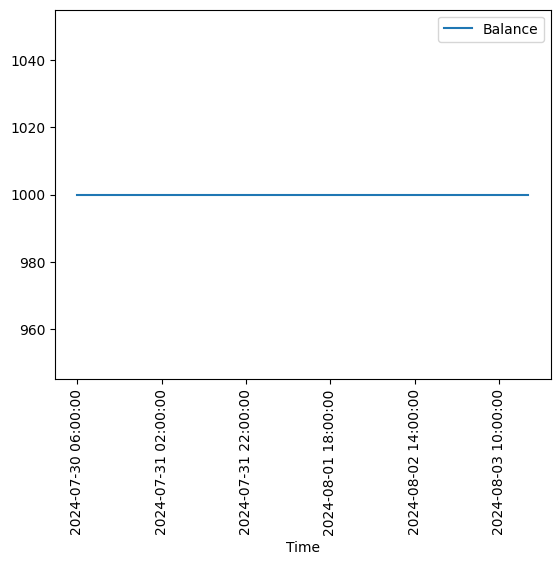

In [103]:
while True:
        # Get new hour data
        hour_data = pd.DataFrame(client.get_historical_klines('BTCUSDT',
                                Client.KLINE_INTERVAL_1HOUR,
                                        str(2) + ' hour ago UTC'))

        # First 6 column represent Time and OHLCV values
        hour_data = hour_data.iloc[:, :6]
        hour_data.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']

        # Convert first column into datetime
        hour_data['Time'] = pd.to_datetime(hour_data['Time'], unit='ms')
        for column in hour_data.columns:
                if column != 'Time':
                        hour_data[column] = hour_data[column].astype(float)

        # Set Time as index
        hour_data.set_index('Time', inplace=True)

        # Join with old data
        raw_df.drop(raw_df.tail(1).index,inplace=True)
        raw_df = pd.concat([raw_df, hour_data])

        # Get TAs and Trading Signals
        df = get_ta(raw_df)
        df = get_signal(df)

        # Simulate Trade
        if (df.iloc[-2, -1] >= 2) & (open_trade == False):
                coin = (balance / df.iloc[-1,0]) *0.999
                balance = 0
                bought_price = df.iloc[-1,0]
                open_trade = True
        elif (df.iloc[-2, -1] <= -2) & (open_trade == True):
                open_trade = False
                print(f"PnL:{(df.iloc[-1,0]-bought_price)/bought_price * 100}")
                balance = coin * df.iloc[-1,0] *0.999
                coin = 0

        balance_dict[f'{df.index[-1]}'] =  balance + coin*df.iloc[-1,0]
        balance_df = pd.DataFrame.from_dict(balance_dict.items())
        balance_df.columns = ['Time', 'Balance']
        balance_df
        print(f"Concencus: {df.iloc[-2,-1]}")
        print(f"Current Balance: {balance} USD and {coin} BTC at {df.index[-1]}")
        balance_df.plot(kind='line', x='Time', y='Balance')
        plt.xticks(rotation=90)
        plt.show();

        sleep(3600)
     